# Исследование объявлений о продаже квартир

## Введение

**Целью данного исследования** является определение ключевых факторов, влияющих на рынучную стоимость квартир. **Исследование построено на** данных сервиса Яндекс.Недвижимость (архиве объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет). При этом часть данных была заполнена пользователями, другая часть - получена автоматически на основе картографических данных. 

**Потребность в исследовании** связана с необходимостью построения автоматизированной системы, которая по параметрам, влияющим на рыночную стоимость объектов недвижимости, смогла бы отслеживать аномалии и мошенническую деятельность.

Иследование состоит из **следующих этапов**:

1. [Обзор данных и их предобработка](#step_1):
    * [Импорт библиотек](#step_1.1);
    * [Общая информация о данных](#step_1.2);
    * [Обработка пропусков и дубликатов, проверка данных](#step_1.3);
    * [Расчёт дополнительных параметров](#step_1.4);
    * [Вывод](#step_1.5).
2. [Исследовательский анализ данных](#step_2):
    * [Анализ площади, цены, числа комнат и высоты потолков](#step_2.1);
    * [Анализ времени продажи квартиры](#step_2.2);
    * [Поиск и удаление редких и выбивающихся значений](#step_2.3);
    * [Выделение и анализ факторов, влияющих на стоимость квартиры](#step_2.4);
    * [Анализ недвижимости по расположению](#step_2.5);
    * [Вывод](#step_2.6).
3. [Общий вывод](#step_3);
4. [Рекомендации](#step_4).

**Результатом исследования** являются рекомендации по построению автоматизированной системы, способной отслеживать аномалии и мошенническую деятельность на рынке недвижимости в г.Санкт-Петербурге и пригороде.

## Этап 1. Обзор данных и их предобработка <a id='step_1'></a>

### Импорт библиотек <a id='step_1.1'></a>

In [1]:
import pandas as pd
import numpy as np
from IPython import display

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import matplotlib.pyplot as plt
import seaborn as sns

### Общая информация о данных <a id='step_1.2'></a>

In [2]:
# Прочитаем файл real_estate_data.csv с информацией об объявлениях и сохраним его в переменной apartments_info.
apartments_info = pd.read_csv('C:/Users/Public/Jupyter/real_estate_data.csv', sep='\t')
apartments_info.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
# Получим общую информацию о данных таблицы apartments_info
display.display(data=apartments_info.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Данные представлены в виде таблицы, включающей в себя 23 698 строк и 22 столбца. При этом 3 столбца - с целочисленными данными (тип < int >), 14 столбцов - с числовыми данными типа < float >, 3 столбца типа < object > и 2 столбца с булевым типом (тип < bool >). Разберём, какие в таблице столбцы, и какую информацию они содержат:

- [`total_images`](#images) — число фотографий квартиры в объявлении;
- [`last_price`](#price) — цена на момент снятия с публикации;
- [`total_area`](#area) — площадь квартиры в квадратных метрах (м²);
- [`first_day_exposition`](#publ_date) — дата публикации;
- [`rooms`](#rooms) — число комнат;
- [`ceiling_height`](#height) — высота потолков (м);
- [`floors_total`](#floors_tot) — всего этажей в доме;
- [`living_area`](#liv_area) — жилая площадь в квадратных метрах(м²);
- [`floor`](#floor) — этаж;
- [`is_apartment`](#apts) — апартаменты;
- [`studio`](#studio) — квартира-студия;
- [`open_plan`](#open_plan) — свободная планировка;
- [`kitchen_area`](#kitch_area) — площадь кухни в квадратных метрах (м²);
- [`balcony`](#balcony) — число балконов;
- [`locality_name`](#locality) — название населённого пункта;
- [`airports_nearest`](#airports) — расстояние до ближайшего аэропорта в метрах (м);
- [`cityCenters_nearest`](#center) — расстояние до центра города (м);
- [`parks_around3000`](#parks) — число парков в радиусе 3 км;
- [`parks_nearest`](#parks_near) — расстояние до ближайшего парка (м);
- [`ponds_around3000`](#ponds) — число водоёмов в радиусе 3 км;
- [`ponds_nearest`](#ponds_near) — расстояние до ближайшего водоёма (м);
- [`days_exposition`](#days) — сколько дней было размещено объявление (от публикации до снятия).

Отметим, что есть некоторое несоответствие типа данных в ряде столбцов (например, столбцы `floors_total`, `balcony`, `parks_around3000`, `ponds_around3000` и `days_exposition` должны быть целочисленными, `is_apartment` - булевым, а `first_day_exposition` - тип даты и времени). Кроме того, различное количество значений в столбцах указывает на возможное наличие в таблице пропусков. Пропуски могут быть связаны с "человеческим" фактором, то есть пользователь мог не указать конкретный параметр, предполагая его отсутствие (например, количество балконов или принадлежность к апартаментам); а могут быть связаны с техническими ошибками.

### Обработка пропусков и дубликатов, проверка данных <a id='step_1.3'></a>

#### Обработка пропусков

In [4]:
# Проверим данные на наличие пропусков
apartments_info.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пропуски отмечены в следующих столбцах: 
- [`ceiling_height`](#height) (высота потолков);
- [`floors_total`](#floors_tot) (этажность дома);
- [`living_area`](#liv_area) (жилая площадь);
- [`is_apartment`](#apts) (апартаменты);
- [`kitchen_area`](#kitch_area) (площадь кухни);
- [`balcony`](#balcony) (число балконов);
- [`locality_name`](#locality) (название населённого пункта);
- [`airports_nearest`](#airports) (расстояние до аэропорта);
- [`cityCenters_nearest`](#center) (расстояние до центра города);
- [`parks_around3000`](#parks) (число парков в радиусе 3 км);
- [`parks_nearest`](#parks_near) (расстояние до парка);
- [`ponds_around3000`](#ponds) (число водоёмов в радиусе 3 км);
- [`ponds_nearest`](#ponds_near) (расстояние до водоёма);
- [`days_exposition`](#days) (сколько дней размещено объявление).

Пропуски могут быть связаны с тем, что не все поля являются обязательными для заполнения, а большинство пользователей заполняет только обязательные. Пропуски в ряде столбцов могут быть связаны с тем, что пользователь не упомянул данные параметры в объявлении, соответственно, они пусты. Отсутствие данных в столбцах `is_apartment` и `balcony` может быть равнозначно нулевому значению параметра (однако, это следует проверить).

##### Высота потолков <a id='height'></a>

In [5]:
apartments_info['ceiling_height'].isna().mean()

0.38799105447487237

Пропуски по столбцу, характеризующему высоту потолков составляют более 38% от выборки. Это очень большая величина, поэтому их следует заполнить.

In [6]:
apartments_info['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Разброс значений высоты потолков не очень высок. Есть и странное максимальное значение в 100 метров, но, скорее всего, человек ошибся и написал значение в неверных единицах измерения (сантиметрах), т.е. оно соответствует 1 метру. Возможны похожие ошибки и в величинах между третьим квартилем и максимумом.

Поскольку в данном столбце пропуски составляют около 40%, их заполнение одним числом выглядит слишком опрометчивым решением. Найдём через корреляцию те столбцы, при помощи которых мы можем произвести заполнение.

In [7]:
Correlation = apartments_info.corr()
Correlation.sort_values(by='ceiling_height', ascending=False)['ceiling_height'].reset_index().head()

,index,ceiling_height
0,ceiling_height,1.000000
1,total_area,0.095490
2,living_area,0.090650
3,kitchen_area,0.087641
4,last_price,0.085430


Получили самую сильную связь высоты потолков с общей площадью. Создадим словарь с общей площадью и соответствующим ей медианным значением высоты потолков.

In [8]:
total_area_dict = (apartments_info
                 .pivot_table(index='total_area', values='ceiling_height', aggfunc='median')
                 .sort_values(by='total_area')
                  )

total_area_dict.columns = ['median_ceiling_height']
total_area_dict

,median_ceiling_height
total_area,
12.0,2.550
13.0,3.000
15.0,2.600
17.0,2.725
17.2,2.770
...,...
507.0,4.450
590.0,3.500
618.0,3.400


In [9]:
# добавим отдельным столбцом median_ceiling_height полученный словарь в исходный Датафрейм
apartments_info = apartments_info.merge(total_area_dict, on='total_area', how='left')

# произведём замену пропусков и удалим рабочий столбец с медианным значением высоты потолков
apartments_info['ceiling_height'] = (np.where(apartments_info['ceiling_height'].isna() == True, 
                                              apartments_info['median_ceiling_height'],
                                              apartments_info['ceiling_height']))
apartments_info.drop('median_ceiling_height', axis='columns', inplace=True)

# проверим количество оставшихся пропусков по столбцу
apartments_info['ceiling_height'].isna().mean()

0.02645681252373518

Осталось всего 2,6% пропусков по столбцу, их мы можем заменить медианным значением высоты потолков.

In [10]:
apartments_info['ceiling_height'] = apartments_info['ceiling_height'].fillna(apartments_info['ceiling_height'].median())

##### Этажность дома <a id='floors_tot'></a>

In [11]:
apartments_info['floors_total'].isna().mean()

0.0036288450989493226

Пропуски по столбцу, характеризующему этажнность дома, составляют около 0,4% от выборки по столбцу. Это немного, но их мы тоже можем попробовать заполнить.

In [12]:
Correlation.sort_values(by='floors_total', ascending=False)['floors_total'].reset_index().head()

,index,floors_total
0,floors_total,1.000000
1,floor,0.678059
2,balcony,0.194065
3,kitchen_area,0.163944
4,airports_nearest,0.108288


Значения в столбце имеют тесную связь с этажом, указанном в объявлениях жилья. Заполним по медианному значению в рамках категории этажей.

In [13]:
floors_dic = apartments_info.pivot_table(index='floor', values='floors_total', aggfunc='median').reset_index()

In [14]:
for floor in range(apartments_info['floor'].min(), (apartments_info['floor'].max()+1)):
    apartments_info.loc[apartments_info['floor'] == floor, 'floors_total'] = (
        apartments_info.loc[apartments_info['floor'] == floor, 'floors_total']
        .fillna(floors_dic[floors_dic['floor'] == floor]['floors_total'].sum()))

In [15]:
apartments_info['floors_total'].describe()

count    23699.000000
mean        10.681759
std          6.599383
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

После заполнения пропусков, у нас остались данные по квартирам, расположенным в домах с этажностью от 1 до 60. При этом медианное значение близко к среднему (9-10 этажей).

##### Жилая площадь <a id='liv_area'></a>

In [16]:
apartments_info['living_area'].describe()

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

In [17]:
apartments_info['living_area'].isna().mean()

0.08029874678256467

Пропуски по столбцу, характеризующему жилую площадь, составляют около 8% от выборки по столбцу. Это немаленькая величина, поэтому их следует заполнить.
Еще раз посмотрим на корреляцию: найдём, от какого фактора больше всего зависит жилая площадь.

In [18]:
Correlation.sort_values(by='living_area', ascending=False)['living_area'].reset_index().head()

,index,living_area
0,living_area,1.000000
1,total_area,0.939537
2,rooms,0.845977
3,last_price,0.566492
4,kitchen_area,0.428674


Жилая площадь в большей степени зависит от общей площади: соответственно, пропущенные значения будем заполнять, исходя из этого параметра. Однако, не вся площадь является жилой, и их соотношение будет зависеть от количества комнат. Поэтому заполнение пропусков необходимо производить по медиане для категорий - количества комнат.

По тому же принципу следует заполнять пропущенные значения площади кухни. Вернёмся к данному пункту позже, и обработаем пропуски жилой площади вместе с пропусками столбца площади кухни.

##### Апартаменты <a id='apts'></a>

In [19]:
apartments_info['is_apartment'].describe()

count      2775
unique        2
top       False
freq       2725
Name: is_apartment, dtype: object

In [20]:
apartments_info['is_apartment'].unique()

array([nan, False, True], dtype=object)

In [21]:
apartments_info['is_apartment'].isna().mean()

0.8829064517490189

Пропуски по столбцу, характеризующему принадлежность недвижимости к апартаментам, близки к 90% от выборки по столбцу. Это очень большая величина, поэтому их следует обработать.

Рассмотрим информацию, которую характеризует данный столбец, подробнее. Апартаменты — это нежилые помещения, не относящиеся к жилому фонду, но имеющие необходимые условия для проживания. Соответственно, данный столбец является булевым и может принимать значения либо True, либо False. Скорее всего, если в столбце возникают пропуски, это говорит о том, что пользователь не отметил этот пункт как отвечающий данному условию, то есть ставим в пропуски False.

In [22]:
apartments_info['is_apartment'] = apartments_info['is_apartment'].fillna(False)

##### Площадь кухни <a id='kitch_area'></a>

In [23]:
apartments_info['kitchen_area'].describe()

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

In [24]:
apartments_info['kitchen_area'].isna().mean()

0.09612219924891345

Пропуски по столбцу, характеризующему площадь кухни, составляют около 10% от выборки. Это немаленькая величина, поэтому их следует заполнить.

In [25]:
Correlation.sort_values(by='kitchen_area', ascending=False)['kitchen_area'].reset_index().head()

,index,kitchen_area
0,kitchen_area,1.000000
1,total_area,0.609121
2,last_price,0.519869
3,living_area,0.428674
4,rooms,0.269945


Наиболее тесная связь площади кухни наблюдается с общей площадью. Поэтому, как и предполагалось выше, заполнение пропусков площади кухни будет производиться по тому же принципу, что и заполнение пропусков жилой площади.

In [26]:
# Добавим столбцы доли жилой площади в общей и доли кухни в общей площади
apartments_info['kitchen_index'] = apartments_info['kitchen_area'] / apartments_info['total_area']
apartments_info['living_index'] = apartments_info['living_area'] / apartments_info['total_area']

Поскольку для разного количества комнат доля площади жилой площади и доля площади кухни может отличаться, заполнение пропусков необходимо производить по медиане для категорий - количества комнат.

In [27]:
apartments_info['rooms'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 19],
      dtype=int64)

Интересным выглядит количество комнат 0, рассмотрим его более подробно.

In [28]:
apartments_info.query('rooms == 0')[['studio', 'open_plan']].sample(5)

,studio,open_plan
9511,True,False
15714,True,False
13471,True,False
1173,True,False
9817,True,False


Судя по случайной выборке, количество комнат очень часто принимает значение 0, когда недвижимость относится к типу студии <a id='studio'></a>, либо имеет свободную планировку <a id='open_plan'></a>. Проверим варианты количества комнат для разных булевых значений указанных столбцов. Заполним те пропуски, для которых либо значение столбца `studio`, либо столбца `is_arartment` принимает значение 'True'.

In [29]:
print("Уникальные значения количества комнат для студии: {}"
      .format(apartments_info.query('studio == True')['rooms'].sort_values().unique()))
print("Уникальные значения количества комнат для свободной планировки: {}"
      .format(apartments_info.query('open_plan == True')['rooms'].sort_values().unique()))

Уникальные значения количества комнат для студии: [0 1]
Уникальные значения количества комнат для свободной планировки: [0 1 2 3 4 5]


Проверим, что у нас нет пересечений. То есть там, где `studio` принимает значение 'True', `open_plan` будет принимать значения 'False'.

In [30]:
apartments_info.query('studio == True')['open_plan'].unique()

array([False])

У нас нет недвижимости, и относящейся к студии, и имеющей свободную планировку.

Поскольку мы будем заполнять оставшиеся пропуски в значениях площади кухни и жилой площади по общей площади и количеству комнат, изучим значения, которые принимают эти показатели для студий и свободной планировки.

In [31]:
#для студии
(apartments_info
     .query('studio == True')
     .pivot_table(index='rooms',
                  values='total_area',
                  aggfunc=['min', 'median', 'max'])
     .sort_values(by='rooms')
)

,min,median,max
,total_area,total_area,total_area
rooms,,,
0,15.5,26.0,98.4
1,22.0,27.0,34.0


На самом деле, студия представляет собой одну комнату с какой-то определенной площадью. Исходя из этого определения, и из того, что медианное значение площади студии для 0 и для 1 комнаты очень близко, было принято решение заменить значения комнат 0 для студии на 1.

In [32]:
apartments_info.loc[((apartments_info['studio'] == True) & (apartments_info['rooms'] == 0)), 'rooms'] = 1

In [33]:
#для свободной планировки
open_plan_pivot = (apartments_info
                       .query('open_plan == True')
                       .pivot_table(index='rooms',
                                    values='total_area',                                    
                                    aggfunc=['min', 'median', 'max'])
                       .sort_values(by='rooms')
                  )
open_plan_pivot

,min,median,max
,total_area,total_area,total_area
rooms,,,
0,16.0,26.10,371.0
1,36.7,39.00,44.2
2,51.0,51.00,51.0
3,59.0,61.75,64.5
4,97.2,97.20,97.2
5,157.0,157.00,157.0


Отметим, что в категории свободной планировки 0 комнат - это, скорее всего, отсутствующая в данных информация, то есть категория, соответствующая 0 комнат по площади может относиться как к 1, так и к 5 комнатам. В связи с этим, изменим количество комнат с 0 на другие значения (от 1 до 5), исходя из площади недвижимости.

In [34]:
def op_pl_change(data):
    if data <= open_plan_pivot.query('rooms==1')['max']['total_area'].sum():
      return 1
    elif data <= open_plan_pivot.query('rooms==2')['max']['total_area'].sum():
      return 2
    elif data <= open_plan_pivot.query('rooms==3')['max']['total_area'].sum():
      return 3
    elif data <= open_plan_pivot.query('rooms==4')['max']['total_area'].sum():
      return 4
    else:
      return 5

In [35]:
apartments_info.loc[apartments_info['open_plan'] == True, 'rooms'] = apartments_info['total_area'].apply(op_pl_change)

Заменим пропуски жилой площади и площади кухни через медианное значение доли жилой площади в общей и доли кухни в общей площади. При этом медианы долей будут расчитаны отдельно для каждого из значений количества комнат. Для этого создадим словарь с медианными значениями долей для количества комнат от 1 до 5. А затем, обращаясь к словарю, произведем заполнение пропущенных значений.

In [36]:
area_indexes_dic = (apartments_info
                    .pivot_table(index='rooms', values=['kitchen_index', 'living_index'], aggfunc='median')
                    .reset_index())
area_indexes_dic

,rooms,kitchen_index,living_index
0,1,0.247839,0.484848
1,2,0.161075,0.585009
2,3,0.128571,0.631667
3,4,0.112245,0.659740
4,5,0.105386,0.651842
5,6,0.099502,0.679412
6,7,0.083717,0.681670
7,8,0.109170,0.688475
8,9,0.049620,0.628251
9,10,0.091624,0.653103


In [37]:
for room in range(1, 20):
    apartments_info.loc[apartments_info['rooms'] == room, 'living_area'] = (
        apartments_info.loc[apartments_info['rooms'] == room, 'living_area']
        .fillna(apartments_info.loc[apartments_info['rooms'] == room, 'total_area'] *
                area_indexes_dic[area_indexes_dic['rooms'] == room]['living_index'].sum()))
    apartments_info.loc[apartments_info['rooms'] == room, 'kitchen_area'] = (
        apartments_info.loc[apartments_info['rooms'] == room, 'kitchen_area']
        .fillna(apartments_info.loc[apartments_info['rooms'] == room, 'total_area'] *
                area_indexes_dic[area_indexes_dic['rooms'] == room]['kitchen_index'].sum()))

##### Число балконов <a id='balcony'></a>

In [38]:
apartments_info['balcony'].describe()

count    12180.000000
mean         1.150082
std          1.071300
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: balcony, dtype: float64

In [39]:
apartments_info['balcony'].isna().mean()

0.4860542638929913

Пропуски по столбцу, характеризующему число балконов, составляют около 50% от выборки по столбцу. Это очень большая величина, поэтому их следует заполнить. Скорее всего, если в столбце присутствуют пропуски, это говорит о том, что пользователь не отметил этот пункт как отвечающий данному условию, то есть ставим в пропуски 0.

In [40]:
apartments_info['balcony'] = apartments_info['balcony'].fillna(0)

##### Населённый пункт <a id='locality'></a>

In [41]:
len(apartments_info['locality_name'].sort_values().unique())

365

In [42]:
apartments_info['locality_name'].isna().mean()

0.002067597788936242

У нас имеется информация о недвижимости, расположенной в 365 населённых пунктах.

Пропуски по столбцу, характеризующему название населённого пункта составляют около 0,2% от выборки по столбцу. Это несущественно. Кроме того, у нас нет необходимой информации для его заполнения, такой как координаты, или расположение относительно центра. К примеру, есть информация о расстоянии до центра, но нет направления (юг, север, запад, восток), поэтому ошибочно будет приравнивать пропуск известному пункту с похожим расстоянием до центра.
В связи с этим данные пропуски можно не заполнять.

##### Расстояние до аэропорта <a id='airports'></a>

In [43]:
apartments_info['airports_nearest'].describe()

count    18157.000000
mean     28793.672193
std      12630.880622
min          0.000000
25%      18585.000000
50%      26726.000000
75%      37273.000000
max      84869.000000
Name: airports_nearest, dtype: float64

In [44]:
apartments_info['airports_nearest'].isna().mean()

0.23384952951601334

Пропуски по столбцу, характеризующему расстояние до ближайшего аэропорта, составляют около 23% от выборки по столбцу. Это немаленькая величина, но медианное и среднее значение не подойдут для заполнения пропусков.

Эти данные получены автоматически на основе картографических данных. Это, скорее всего, говорит о том, что аэропорта либо нет в данном городе, либо он находится очень далеко (свыше максимального значения для данного столбца). Таким образом, эти значения не будут существенными при определении цен на недвижимость.

Мы можем не заполнять пропуски по столбцу.

##### Расстояние до центра города <a id='center'></a>

In [45]:
apartments_info['cityCenters_nearest'].describe()

count    18180.000000
mean     14191.277833
std       8608.386210
min        181.000000
25%       9238.000000
50%      13098.500000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

In [46]:
apartments_info['cityCenters_nearest'].isna().mean()

0.23287902443141062

Пропуски по столбцу, характеризующему расстояние до центра города, составляют около 23% от выборки по столбцу. Это большая величина, но медианное и среднее значение также не подойдут для заполнения пропусков, как и в случае с расстоянием до аэропорта.

Эти данные также получены автоматически на основе картографических данных. Пропуски в них, скорее всего, указывают на то, что населенный пункт слишком мал, чтобы в нём выделялся центр. Эти значения также не будут существенными при определении цен на недвижимость.

Мы можем не заполнять пропуски.

##### Число парков <a id='parks'></a>

In [47]:
apartments_info['parks_around3000'].describe()

count    18181.000000
mean         0.611408
std          0.802074
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64

In [48]:
apartments_info['parks_around3000'].isna().mean()

0.232836828558167

Пропуски по столбцу, характеризующему число парков в радиусе 3 км составляют 23% от выборки по столбцу. Это большая величина, поэтому пропуски следует заполнить там, где это возможно.

Мы могли бы произвести заполнение, исходя из столбца с данными о расстоянии до ближайшего парка.

In [49]:
(apartments_info.loc[(apartments_info['parks_around3000'].isna() == True) & 
                     (apartments_info['parks_nearest'].isna() != True), 'parks_nearest'].count())

0

Однако, в тех строках, в которых отсутствуют данные по количеству парков в радиусе 3 км, также отсутствуют данные о расстоянии до ближайших парков. Оставим их незаполненными.

##### Расстояние до парка <a id='parks_near'></a>

In [50]:
apartments_info['parks_nearest'].describe()

count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

In [51]:
apartments_info['parks_nearest'].isna().mean()

0.6590995400649816

Пропуски по столбцу, характеризующему расстояние до ближайшего парка, составляют около 66% от выборки по столбцу. Эти данные тоже получены автоматически на основе картографических данных. Это, скорее всего, говорит о том, что парка нет в населенном пункте. Таким образом, эти значения не будут существенными при определении цен на недвижимость.

Однако, у нас есть столбец с количеством парков в радиусе 3 км. Предположим, что была допущена ошибка при сборе или обработке данных, и данные были пропущены в данном столбце из-за этого. Попробуем восстановить то, что возможно, из еще одного столбца с данными.

Если количество парков в радиусе 3 км непропущенное, поставим медианное значение расстояния в рамках такого количества парков. Создадим словарь, из которого циклом произведем заполнение пропусков.

In [52]:
parks_dic = apartments_info.pivot_table(index='parks_around3000', values='parks_nearest', aggfunc='median').reset_index()
parks_dic

,parks_around3000,parks_nearest
0,0.0,3127.0
1,1.0,502.0
2,2.0,365.0
3,3.0,307.0


Несмотря на то, что есть незаполненные данные по паркам в расстоянии 3 км, и расстоянии до парков поблизости, есть и значения количества парков от 0 до 3. А это значит, что парки поблизости есть, но данные были каким-то образом утеряны или несобраны (возможная ошибка, о которой говорилось выше). Заполним все пропуски, кроме значений для 0 парков.

In [53]:
for number in range(1, 4):
    median = parks_dic[parks_dic['parks_around3000'] == number]['parks_nearest'].sum().astype(int)
    apartments_info.loc[apartments_info['parks_around3000'] == number, 'parks_nearest'] = (
        apartments_info.loc[apartments_info['parks_around3000'] == number, 'parks_nearest'].fillna(median))

Оставшиеся пропуски ставим незаполненными.

##### Число водоёмов <a id='ponds'></a>

In [54]:
apartments_info['ponds_around3000'].describe()

count    18181.000000
mean         0.770255
std          0.938346
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64

In [55]:
apartments_info['ponds_around3000'].isna().mean()

0.232836828558167

Пропуски по столбцу, характеризующему число водоёмов в радиусе 3 км составляют 23% от выборки по столбцу. Это большая величина, поэтому пропуски следует заполнить там, где это возможно.

Мы могли бы произвести заполнение, исходя из столбца с данными о расстоянии до ближайшего водоёма.

In [56]:
(apartments_info.loc[(apartments_info['ponds_around3000'].isna() == True) & 
                     (apartments_info['ponds_nearest'].isna() != True), 'ponds_nearest'].count())

0

Однако, в тех строках, в которых отсутствуют данные по количеству водоёмов в радиусе 3 км, также отсутствуют данные о расстоянии до ближайших водоёмов. Оставим их незаполненными.

##### Расстояние до водоёма <a id='ponds_near'></a>

In [57]:
apartments_info['ponds_nearest'].describe()

count    9110.000000
mean      517.980900
std       277.720643
min        13.000000
25%       294.000000
50%       502.000000
75%       729.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

In [58]:
apartments_info['ponds_nearest'].isna().mean()

0.6155955947508334

Пропуски по столбцу, характеризующему расстояние до ближайшего водоёма, составляют около 62% от выборки по столбцу. Это существенная величина. Мы можем заполнить пропуски аналогично пропускам расстояния до ближайшего парка.

Сначала создадим словарь с медианным расстоянием для разного количества водоёмов в радиусе 3 км, а затем воспользуемся им.

In [59]:
ponds_dic = apartments_info.pivot_table(index='ponds_around3000', values='ponds_nearest', aggfunc='median').reset_index()
ponds_dic

,ponds_around3000,ponds_nearest
0,1.0,593.0
1,2.0,437.0
2,3.0,305.0


Несмотря на то, что есть незаполненные данные по водоёмам в расстоянии 3 км, и расстоянии до водоёмов поблизости, есть и значения количества водоёмов от 1 до 3. А это значит, что водоёмы поблизости есть, но данные были каким-то образом утеряны или несобраны (возможная ошибка, о которой говорилось выше). Заполним их.

In [60]:
for number in range(1, 4):
    median = ponds_dic[ponds_dic['ponds_around3000'] == number]['ponds_nearest'].sum().astype(int)
    apartments_info.loc[apartments_info['ponds_around3000'] == number, 'ponds_nearest'] = (
        apartments_info.loc[apartments_info['ponds_around3000'] == number, 'ponds_nearest'].fillna(median))

##### Длительность размещения объявления <a id='days'></a>

In [61]:
apartments_info['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [62]:
apartments_info['days_exposition'].isna().mean()

0.13422507278788134

Пропуски по столбцу, характеризующему число дней размещения объявления, составляют 13,5% от выборки по столбцу. Это немаленькая величина, поэтому их следует заполнить.

Однако, по своей сути этот столбец иллюстрирует момент продажи квартиры - ведь если недвижимость продана, нет смысла обновлять объявление и оставлять его на сервисе. Соответственно, мы не можем заполнить пропуски по средней, медиане или еще каким-то метрикам, поскольку не обладаем информацией, когда была продана квартира. А пропуски могут быть связаны с тем, что недвижимость вовсе не была продана, и объявление до сих пор "висит" на сервисе.

Проверим это, посчитав количество таких объявлений по дате выставления.

In [63]:
(apartments_info
                 .loc[apartments_info['days_exposition'].isna() == True]
                 .pivot_table(index='first_day_exposition', values='last_price', aggfunc='count')
                 .sort_values(by='last_price', ascending=False)
                 .head(20)
)

,last_price
first_day_exposition,
2019-04-22T00:00:00,46
2019-04-18T00:00:00,44
2019-04-29T00:00:00,36
2019-04-08T00:00:00,36
2019-04-04T00:00:00,36
2019-04-17T00:00:00,35
2019-04-26T00:00:00,35
2019-04-15T00:00:00,34
2019-04-24T00:00:00,32


Действительно, большинство таких объявлений было выставлено в апреле 2019 года, а значит квартиры еще не были проданы, объявление не было "закрыто", а в столбце не появилось соответствующей отметки.

Оставим пропуски в данном столбце незаполненными.

In [64]:
# Проверим, что пропущенных значений не осталось там, где их можно было заменить
apartments_info.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
kitchen_index            2278
living_index             1903
dtype: int64

Дозаполним пропуски в столбцах с индексом площади кухни и жилой площади.

In [65]:
apartments_info['kitchen_index'] = apartments_info['kitchen_area'] / apartments_info['total_area']
apartments_info['living_index'] = apartments_info['living_area'] / apartments_info['total_area']

##### Число фотографий <a id='images'></a>

In [66]:
apartments_info['total_images'].describe()

count    23699.000000
mean         9.858475
std          5.682529
min          0.000000
25%          6.000000
50%          9.000000
75%         14.000000
max         50.000000
Name: total_images, dtype: float64

Несмотря на то, что разброс числа фотографий достаточно большой, среднее значение близко к медианному и составляет около 9-10 фотографий.

#### Обработка дубликатов

In [67]:
# Установим наличие дубликатов в данных
apartments_info.duplicated().sum()

0

В данных отсутствуют дубликаты.

#### Замена типа данных

Еще раз посмотрим на подробную информацию о данных.

In [68]:
apartments_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23699 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Нам необходимо заменить тип данных для столбцов:

- last_price: с float на int, поскольку это очень большие величины, в которых в рамках анализа нет смысла выделять копейки.
- first_day_exposition: с object на datetime, поскольку этот столбец имеет данные о дате и времени.
- floors_total: с float на int, так как количество этажей в доме не может быть нецелочисленным.
- balcony: с float на int, так как количество балконов тоже может быть только целочисленным.
- airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest: с float на int, так как расстояние нам не требуется изучать до десятичных и сотых дробей метров.
- parks_around3000, ponds_around3000: с float на int, так как это количество, которое должно быть целочисленным.
- days_exposition: с float на int, так как количество дней в рамках анализа нам не требуется дробить на доли.

Произведём замену.

In [69]:
# Изменение типа данных с "float" на "int" данных, в которых нет пропущенных значений
apartments_info[['last_price', 'floors_total', 'balcony']] = (
    apartments_info[['last_price', 'floors_total', 'balcony']].astype('int'))
# Изменение типа данных с "object" на "datetime"
apartments_info['first_day_exposition'] = pd.to_datetime(apartments_info['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
# Проверка изменения в типе данных
apartments_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23699 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int32         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int32         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

Мы изменили тип данных везде, где это возможно.

### Расчёт дополнительных параметров <a id='step_1.4'></a>

#### Цена квадратного метра

Цена квадратного метра - это соотношение окончательной цены к общей площади. Добавим к датафрейму столбец `price_per_meter` и рассчитаем его делением столбца `last_price` на столбец `total_area`.

In [70]:
apartments_info['price_per_meter'] = (apartments_info['last_price'] / apartments_info['total_area']).astype(int)

#### День недели, месяц и год публикации объявления <a id='publ_date'></a>

День недели, месяц и год публикации объявления извлекаются из столбца `first_day_exposition` через команду `DatetimeIndex` и атрибуты `weekday`, `month` и `year`, соответственно. Получим, таким образом три новых столбца в датафрейме: `weekday_exposition`, `month_exposition`, `year_exposition`.

In [71]:
# день недели публикации объявления
apartments_info['weekday_exposition'] = pd.DatetimeIndex(apartments_info['first_day_exposition']).weekday
# месяц публикации объявления
apartments_info['month_exposition'] = pd.DatetimeIndex(apartments_info['first_day_exposition']).month
# год публикации объявления
apartments_info['year_exposition'] = pd.DatetimeIndex(apartments_info['first_day_exposition']).year

#### Этаж квартиры <a id='floor'></a>

Выделим 3 категории по этажу квартиры: первый, последний и другой. Если значение в столбце `floor` равно 1 - это первый; если оно равно значению в столбце `floors_total` (всего этажность дома) - это последний; в остальных случаях - другой. Создадим новый столбец в датафрейме `floor_category` и заполним его, исходя из указанных условий (через функцию определения категории).

In [72]:
# функция определения категории
def floor_group(row):
        if row[8] == 1:
            return 'первый'
        if row[8] == row[6]:
            return 'последний'
        else:
            return 'другой'

In [73]:
apartments_info['floor_category'] = apartments_info.apply(floor_group, axis=1)

#### Соотношения жилой и кухонной площади к общей

У нас уже имеются такие столбцы в данных - мы их рассчитывали для заполнения пустых значений в данных жилой и кухонной площади. Это столбцы `living_index` и `kitchen_index`.

### Вывод <a id='step_1.5'></a>

Мы обнаружили пустые значения практически во всех столбцах с данными, кроме количества фотографий, цены, площади, даты размещения, количестве комнат, этаже, принадлежности к студии и свободной планировке. Причины могут быть разными. Часть пропусков могла быть связана с тем, что клиент не указал число в пункте, по умолчанию предполагая отсутствие данного фактора в недвижимости. Часть пропусков могла быть связана с техническими моментами выгрузки или заполнения. Также есть пропуски в данных, заполненных автоматически на основе картографических - эти пропуски могут быть связаны со слишком большой отдаленностью объектов, либо их отсутствием в населенном пункте. Все пропуски были обработаны и заполнены на основе имеющейся информации и предпосылках о причинах их наличия.

Также мы обнаружили, что многие столбцы, характеризующие количество (этажей, балконов, парков и т.п.) имеют тип данных < float >, но по логике могут принимать только целочисленные значения, поэтому их тип был изменен на < int > (для тех столбцов, в которых мы смогли заполнить пропуски). Часть столбцов, хотя и может примать дробные значения, в рамках анализа интересует нас только в целых величинах, поэтому их тип также был изменен на < int >. Кроме того, был изменен тип данных столца с датой публикации объявления - с < object > на < datetime >.

Кроме того, нами были рассчитаны и добавлены в таблицу данные по цене квадратного метра; дню недели, месяцу и году публикации объявления; категории этажа квартиры; соотношению жилой и кухонной площадей к общей площади. Эти вспомогательные данные в последующем будут нужны для исследовательского анализа.

## Этап 2. Исследовательский анализ данных <a id='step_2'></a>

### Анализ площади, цены, числа комнат и высоты потолков <a id='step_2.1'></a>

Изучим корреляцию между параметрами.

In [74]:
apartments_info[['total_area', 'last_price', 'rooms', 'ceiling_height']].corr()

,total_area,last_price,rooms,ceiling_height
total_area,1.000000,0.653675,0.761508,0.107826
last_price,0.653675,1.000000,0.366096,0.082867
rooms,0.761508,0.366096,1.000000,0.072649
ceiling_height,0.107826,0.082867,0.072649,1.000000


Наблюдается сильное влияние общей площади на цену. В свою очередь количество комнат влияет на площадь, но слабо влияет на цену (влияние параметра является косвенным через площадь). Высота потолков связана только с площадью, что, скорее всего, обусловлено типом дома и квартир.

#### Параметр площадь квартиры <a id='area'></a>

Изучим информацию о площади квартир.

In [75]:
apartments_info['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

У нас имеется 23 699 значений от 12 квадратных метров, до 900 квадратных метров. При этом средняя и медиана значительно разнятся: средняя площадь составляет 60 м2, а медианное значение - 52 м2. Стандартное отклонение велико: около 35,7 м2. Мы получаем очень большой разброс данных.

In [76]:
# Создадим функцию для построения боксплота
def boxplot(column, measure):
    fig, ax = plt.subplots()
    plt.title('Распределение '+column+' (без выбросов)')
    ax = apartments_info.boxplot(column, showfliers=False)
    plt.ylabel(measure)
    plt.show()

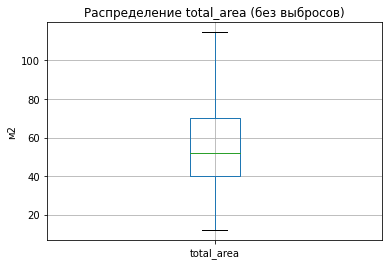

In [77]:
# Отрисуем боксплот для площади квартиры
boxplot('total_area', 'м2')

Видим, что большая часть значений лежит в диапазоне от 40 до 70 квадратных метров, что выглядит правдоподобно.

#### Параметр цены квартиры <a id='price'></a>

Изучим информацию о ценах квартир.

In [78]:
apartments_info['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

У нас имеется 23 699 значений от 12 тысяч ден.ед. до 763 миллионов ден.ед. Это невероятно большой разброс! Средняя и медиана разнятся: средняя цена составляет 6,5 миллионов ден.ед., а медианное значение - 4,6 миллионов ден.ед. Стандартное отклонение очень велико: около 11 миллионов ден.ед.

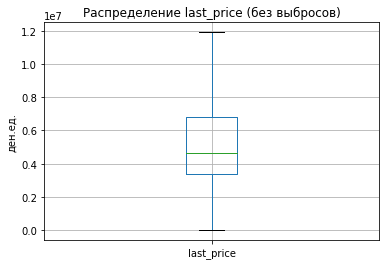

In [79]:
# Отрисуем боксплот для цен на квартиры
boxplot('last_price', 'ден.ед.')

Видим, что большая часть значений лежит в диапазоне от 3,5 до 7 миллионов ден.ед. Поскольку исследование проводится для квартир в Санкт-Петербурге и пригороде, значения выглядят правдоподобно.

#### Параметр число комнат <a id='rooms'></a>

Изучим информацию о количестве комнат в квартире.

In [80]:
apartments_info['rooms'].describe()

count    23699.000000
mean         2.079117
std          1.066342
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

У нас имеется 23 699 значений от 1 до 19 комнат. Это относительно небольшой разброс. Средняя и медиана практически не отличаются: они близки к 2 комнатам. Стандартное отклонение также невелико: около 1.

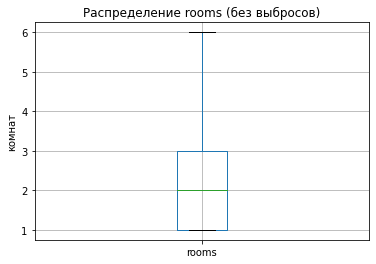

In [81]:
# Отрисуем боксплот для цен на квартиры
boxplot('rooms', 'комнат')

Видим, что большая часть значений лежит в диапазоне от 1 до 3 комнат, что действительно соответствует среднестатистическим квартирам, но имеется очень длинный хвост. С другой стороны, это могут быть единичные "элитные" квартиры с очень большой площадью и числом комнат.

#### Параметр высота потолков

Изучим информацию о высоте потолков в квартирах.

In [82]:
apartments_info['ceiling_height'].describe()

count    23699.000000
mean         2.727060
std          1.028139
min          1.000000
25%          2.550000
50%          2.600000
75%          2.750000
max        100.000000
Name: ceiling_height, dtype: float64

У нас имеется 23 699 значений от 1 до 100 метров. Это очень большой разброс, в котором максимальное значение выглядит неправдоподобно. Средняя и медиана близки: 2,6 - 2,7 метров. Стандартное отклонение около 1.

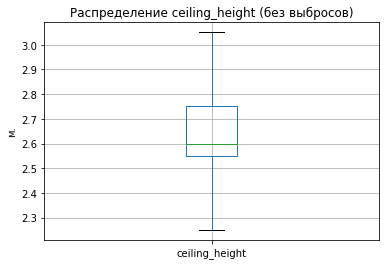

In [83]:
# Отрисуем боксплот для цен на квартиры
boxplot('ceiling_height', 'м.')

Видим, что большая часть значений лежит в диапазоне от 2,55 до 2,75 метров, что соответствует среднестатистическим современным квартирам.

### Анализ времени продажи квартиры <a id='step_2.2'></a>

#### Общая информация, среднее и медиана

In [84]:
apartments_info['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [85]:
len(apartments_info.loc[apartments_info['days_exposition'].isna() == True, 'days_exposition'])

3181

У нас имеется 20 518 значений от 1 дня до 1 580 дней, а также 3 181 незакрытое объявление.

Если рассматривать данные по закрытым объявлениям (или, так называемым, "хорошим" квартирам), в среднем большая часть из них продается за 95 дней (медиана), то есть за 3 месяца. Однако и для данной выборки среднее значение больше медианы почти в 2 раза. Это говорит о том, что в распределении есть длинный хвост высоких значений (или несколько очень больших значений), влияющих на среднее, но не на медиану.

#### Гистограммы

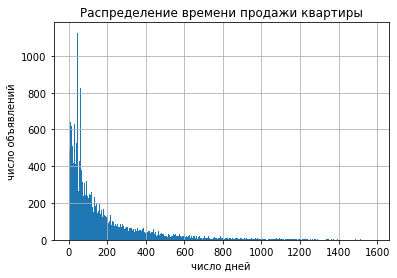

In [86]:
fig, ax = plt.subplots()
plt.title('Распределение времени продажи квартиры')
ax = apartments_info['days_exposition'].hist(bins=365)
plt.xlabel('число дней')
plt.ylabel('число объявлений')
plt.show()

Видим, какое огромное число квартир не продано. Будем считать, что продажи прошли быстро, если квартира продана в срок до 1 года (менее 365 дней). Всё, что свыше 1 года - это необычно долго.

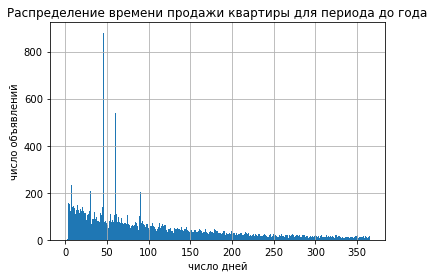

In [87]:
fig, ax = plt.subplots()
plt.title('Распределение времени продажи квартиры для периода до года')
ax = apartments_info['days_exposition'].hist(bins=365, range=(0, 365))
plt.xlabel('число дней')
plt.ylabel('число объявлений')
plt.show()

Пик продаж для квартир составляет 45 дней. В целом же, очень многие квартиры продаются за год. Причем, большая часть продается достаточно быстро: за 3-4 месяца.

Построим гистограмму для продаж свыше года, но меньше 2 лет.

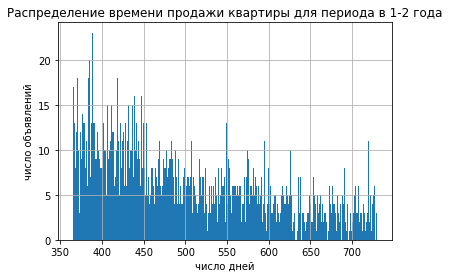

In [88]:
fig, ax = plt.subplots()
plt.title('Распределение времени продажи квартиры для периода в 1-2 года')
ax = apartments_info['days_exposition'].hist(bins=365, range=(365, 730))
plt.xlabel('число дней')
plt.ylabel('число объявлений')
plt.show()

Таких квартир не очень много, но они есть. И на графике наблюдается та же тенденция, что и для очень быстрых продаж: чем быстрее мы продадим квартиру, тем выше ее шанс на продажу. Если квартира "простаивает" и объявление "висит" долго, то чем дольше длится этот процесс, тем меньше шанс на продажу.

Построим гистограмму для продаж за 2-3 года.

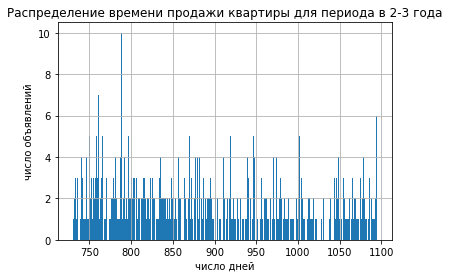

In [89]:
fig, ax = plt.subplots()
plt.title('Распределение времени продажи квартиры для периода в 2-3 года')
ax = apartments_info['days_exposition'].hist(bins=365, range=(730, 1095))
plt.xlabel('число дней')
plt.ylabel('число объявлений')
plt.show()

Таких квартир еще меньше. Что также подтверждает нашу догадку.

### Поиск и удаление редких и выбивающихся значений <a id='step_2.3'></a>

Для обработки редких и выбивающихся значений, построим гистограммы. Автоматизируем процесс построения гистограмм, чтобы ничего не упустить.

In [90]:
def histogram(df, column, bins_hist):
  try:
    # расчёт межквартильного размаха
    quart = df[column].quantile(.75) - df[column].quantile(.25)

    # расчёт нижней границы
    minim = df[column].min()
    quart_min = df[column].quantile(.25) - quart * 3
    if quart_min < minim:
      quart_min = minim
    else:
      quart_min = quart_min
  
    # расчёт верхней границы
    maxim = df[column].max()
    quart_max = df[column].quantile(.75) + quart * 3
    if quart_max > maxim:
      quart_max = maxim
    else:
      quart_max = quart_max
    
    # построение гистограммы в полученном диапазоне
    df.hist(column, bins = bins_hist, range = ((quart_min), (quart_max)))
    plt.title('Распределение '+column)
    plt.xlabel('значения '+column)
    plt.ylabel('распределение')
    print('Среднее значение по столбцу: {:.2f}'.format(df[column].mean()))
    print('Максимальное "хорошее" значение по столбцу: {}'.format(df[(df[column] > quart_min) & (
        df[column] < quart_max)][column].median()))
  except:
    print()

#### Число фотографий

Среднее значение по столбцу: 9.86
Максимальное "хорошее" значение по столбцу: 10.0


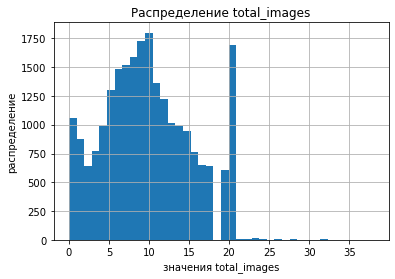

In [91]:
histogram(apartments_info, 'total_images', 40)

Гистограмма по количеству фотографий выглядит близкой к нормальному распределению, но помимо основного пика в 10 фотографий есть явный выброс в 20 фотографий, а также достаточно высокие значения в 0 и 1. После 20 есть длинный хвост с очень малыми величинами.

Поскольку число фотографий не является основным параметром продажи квартир, оставляем все значения в данных.

#### Стоимость

Среднее значение по столбцу: 6541548.77
Максимальное "хорошее" значение по столбцу: 4500000.0


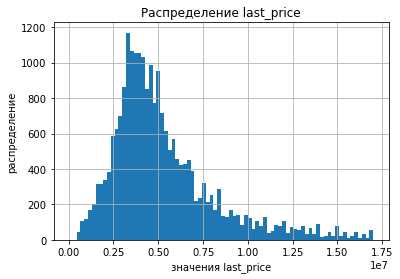

In [92]:
histogram(apartments_info, 'last_price', 80)

Гистограмма по стоимости выглядит как распределение Пуассона. Соответственно, всё, что свыше 17 500 000 ден.ед. - выбросы, которые могут быть исключены.

In [93]:
# доля объявлений стоимостью свыше 17 500 000 ден.ед.
print(len(apartments_info.query('last_price > 17500000')) / len(apartments_info))

0.03839824465167307


Выбросов не мало, но и не так много: около 3-4% от выборки. Мы можем их исключить, чтобы сохранить пуассоновское распределение данных.

Среднее значение по столбцу: 5304590.70
Максимальное "хорошее" значение по столбцу: 4500000.0


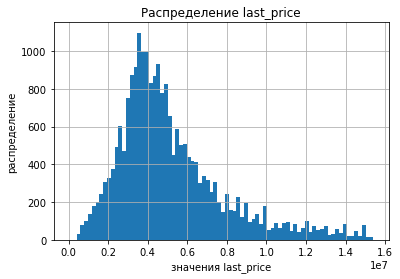

In [94]:
apartments_good_price = apartments_info.query('last_price <= 17500000')
histogram(apartments_good_price, 'last_price', 80)

#### Площадь квартиры

Среднее значение по столбцу: 56.06
Максимальное "хорошее" значение по столбцу: 50.5


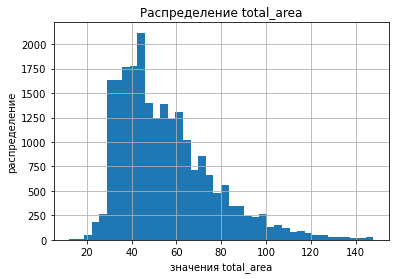

In [95]:
histogram(apartments_good_price, 'total_area', 40)

Гистограмма по стоимости выглядит как распределение Пуассона. Соответственно, всё, что свыше 160 квадратных метров - выбросы, которые могут быть исключены. Также странно выглядят значения менее 20 квадратных метров.

In [96]:
# доля объявлений с площадью менее 20 м2 и свыше 160м2.
print(len(apartments_good_price.query('total_area < 20 or total_area > 160')) / len(apartments_good_price))

0.005309579182939137


Редкие значения составляют менее 1% от выборки. Мы можем их исключить, чтобы сохранить пуассоновское распределение данных.

Среднее значение по столбцу: 55.54
Максимальное "хорошее" значение по столбцу: 50.5


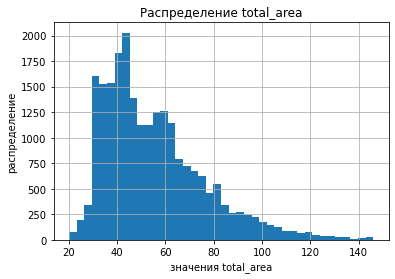

In [97]:
apartments_good_total_area = apartments_good_price.query('total_area <= 160 and total_area >= 20')
histogram(apartments_good_total_area, 'total_area', 40)

#### Число комнат

Среднее значение по столбцу: 1.99
Максимальное "хорошее" значение по столбцу: 2.0


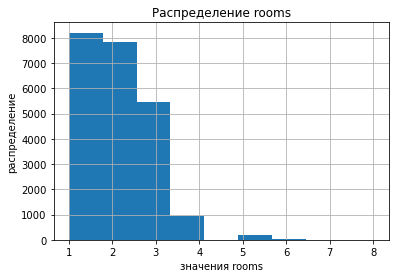

In [98]:
histogram(apartments_good_total_area, 'rooms', 9)

Гистограмма по количеству комнат выглядит близкой к пуассоновскому распределению с пиком в 2. После 5 есть хвост с очень малыми величинами. Однако, даже редкие квартиры с большим количеством комнат могут быть представлены. Например, это может быть какое-то "элитное" жилье с большим числом комнат и огромной площадью.

#### Высота потолков

Среднее значение по столбцу: 2.71
Максимальное "хорошее" значение по столбцу: 2.6


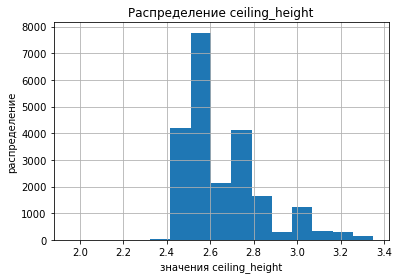

In [99]:
histogram(apartments_good_total_area, 'ceiling_height', 15)

Гистограмма по высоте потолков похожа на пуассоновское распределение с пиком в 2,6. Очень мало значений до 2 и свыше 3,4 метров.

In [100]:
# доля объявлений с потолками менее 2,4 метров и более 3,4 метров
print(len(apartments_good_total_area.query('ceiling_height < 2 or ceiling_height > 3.4')) / len(apartments_good_total_area))

0.015263808011293453


Объявления с потолками ниже 2 м и выше 3,4 м составляют около 1,5%. Это маленькая величина, можем исключить их.

Среднее значение по столбцу: 2.66
Максимальное "хорошее" значение по столбцу: 2.6


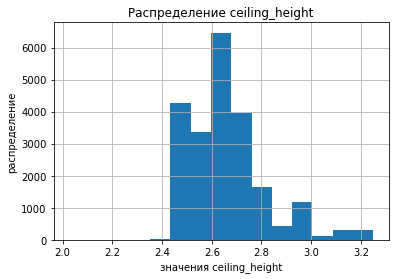

In [101]:
apartments_good_height = apartments_good_total_area.query('ceiling_height <= 3.4 and ceiling_height >= 2')
histogram(apartments_good_height, 'ceiling_height', 15)

#### Этажность дома

Среднее значение по столбцу: 10.85
Максимальное "хорошее" значение по столбцу: 9.0


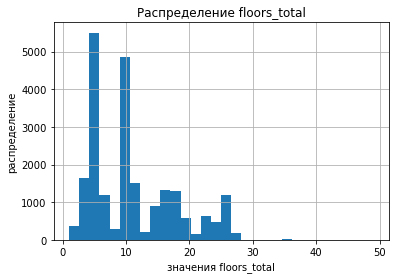

In [102]:
histogram(apartments_good_height, 'floors_total', 30)

Гистограмма по этажности домов выглядит как пуассоновское распределение с двумя пиками в 5 и 10. Это может быть связано с типом дома: старые дома, как правило, строились 5-ти этажными, а новые строятся, в среднем, около 10 этажей. После 28 этажей есть небольшой хвост с очень малыми величинами. После 30 этажей значения практически не встречаются.

In [103]:
# доля объявлений с домами этажностью свыше 30 этажей
print(len(apartments_good_height.query('floors_total > 30')) / len(apartments_good_height))

0.0013439655944807814


Объявления с домами этажностью свыше 30 этажей составляют мизерный процент от данных, мы можем исключить их.

Среднее значение по столбцу: 10.82
Максимальное "хорошее" значение по столбцу: 9.0


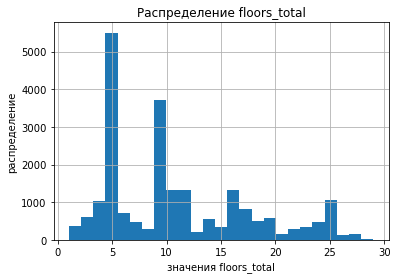

In [104]:
apartments_good_floors_tot = apartments_good_height.query('floors_total <= 30')
histogram(apartments_good_floors_tot, 'floors_total', 25)

##### Жилая площадь

Среднее значение по столбцу: 31.59
Максимальное "хорошее" значение по столбцу: 29.8


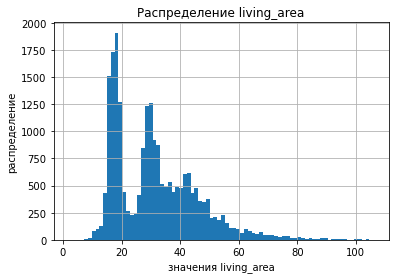

In [105]:
histogram(apartments_good_floors_tot, 'living_area', 80)

Гистограмма по жилой площади выглядит как нормальное распределение с пиком в 18 и 29 квадратных метра. До 10 м2 и после 110 м2 наблюдается мало значений и выбросы. Вид гистограммы схож с гстограммой для этажности дома, и скорее всего, связан с типом домов (старые и новые).

In [106]:
# доля объявлений с жилой площадью менее 10 м2 и более 110 м2
print(len(apartments_good_floors_tot.query('living_area < 10 or living_area > 110')) / len(apartments_good_floors_tot))

0.0016149291225551767


Значения в указанном промежутке составляют менее 1% от данных, мы можем исключить их.

Среднее значение по столбцу: 31.58
Максимальное "хорошее" значение по столбцу: 29.8


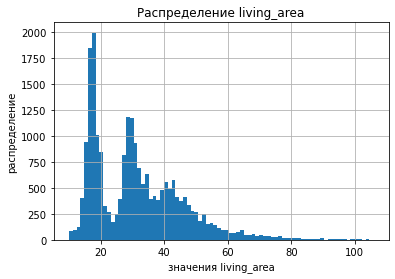

In [107]:
apartments_good_liv_area = apartments_good_floors_tot.query('living_area <= 110 and living_area >= 10')
histogram(apartments_good_liv_area, 'living_area', 80)

#### Этаж

Среднее значение по столбцу: 5.92
Максимальное "хорошее" значение по столбцу: 5.0


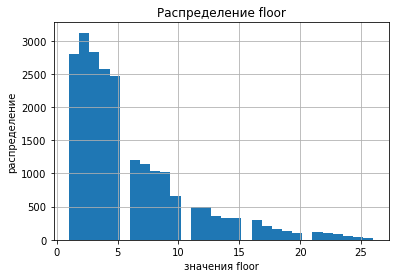

In [108]:
histogram(apartments_good_liv_area, 'floor', 30)

Гистограмма по жилой площади выглядит как пуассоновское распределение с пиком в 2 этажа. Значений свыше 26 этажа очень мало.

#### Площадь кухни

Среднее значение по столбцу: 9.81
Максимальное "хорошее" значение по столбцу: 9.0


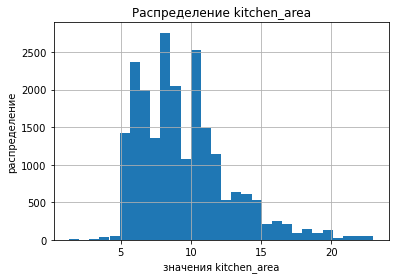

In [109]:
histogram(apartments_good_liv_area, 'kitchen_area', 30)

Гистограмма по площади кухни выглядит как пуассоновское распределение с пиком в 5-10 квадратных метра. До 3 м2 и после 26 м2 наблюдается мало значений и выбросы.

In [110]:
# доля объявлений с кухонной площадью менее 3 м2 и более 26 м2
print(len(apartments_good_liv_area.query('kitchen_area < 3 or kitchen_area > 26')) / len(apartments_good_liv_area))

0.010199496764917326


Значения в указанном промежутке составляют около 1% от данных, мы можем исключить их.

Среднее значение по столбцу: 9.58
Максимальное "хорошее" значение по столбцу: 9.0


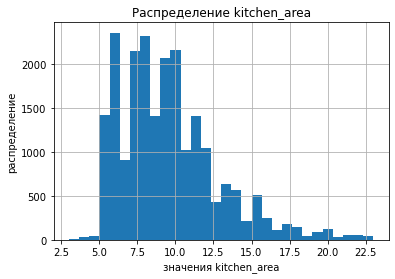

In [111]:
apartments_good_kit_area = apartments_good_liv_area.query('kitchen_area <= 26 and kitchen_area >= 3')
histogram(apartments_good_kit_area, 'kitchen_area', 30)

#### Число балконов

Среднее значение по столбцу: 0.60
Максимальное "хорошее" значение по столбцу: 1.0


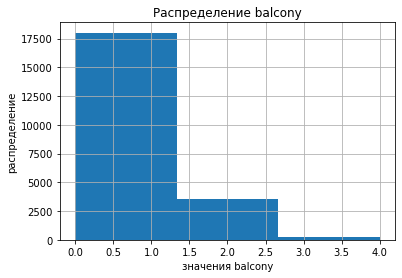

In [112]:
histogram(apartments_good_kit_area, 'balcony', 3)

Гистограмма по числу балконов выглядит как пуассоновское распределение с пиком в 0-1. Значений свыше 4 балконов очень мало значений.

#### Расстояние до аэропорта

Среднее значение по столбцу: 28946.15
Максимальное "хорошее" значение по столбцу: 27155.0


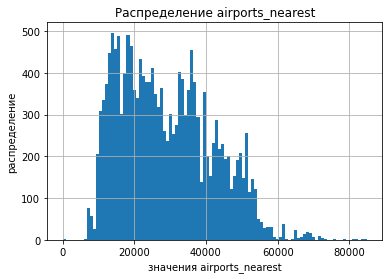

In [113]:
histogram(apartments_good_kit_area, 'airports_nearest', 100)

Гистограмма по расстоянию до ближайшего аэропорта близка к пуассоновскому распределению с широким пиком около 15-35 тысяч метров. До 7000 и после 90000 м наблюдается мало значений.

In [114]:
# доля объявлений с квартирами, для которых расстояние до ближайшего аэропорта менее 7 км и более 90 км
(print(len(apartments_good_kit_area.query('airports_nearest < 7000 or airports_nearest > 90000')) / 
       len(apartments_good_kit_area)))

0.0006355258976803305


Значения в указанном промежутке составляют менее 1% от данных, мы можем исключить их.

Среднее значение по столбцу: 28965.20
Максимальное "хорошее" значение по столбцу: 27166.0


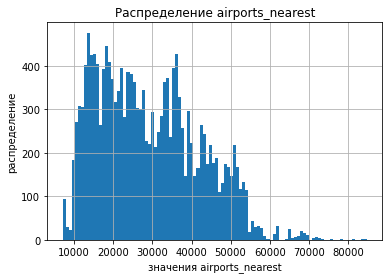

In [115]:
apartments_good_airp_near = apartments_good_kit_area.query('airports_nearest <= 90000 and airports_nearest >= 7000')
histogram(apartments_good_airp_near, 'airports_nearest', 100)

#### Расстояние до центра города

Среднее значение по столбцу: 14778.36
Максимальное "хорошее" значение по столбцу: 13307.0


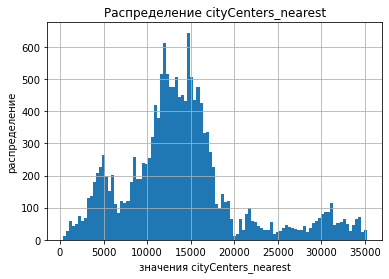

In [116]:
histogram(apartments_good_airp_near, 'cityCenters_nearest', 100)

Гистограмма по расстоянию до центра города близка к пуассоновскому распределению. После 50 000 м наблюдается мало значений.

In [117]:
# доля объявлений с квартирами, для которых расстояние до центра города более 50 км
print(len(apartments_good_airp_near.query('cityCenters_nearest > 50000')) / len(apartments_good_airp_near))

0.010746845378252733


Значения в указанном промежутке составляют около 1% от данных, мы можем исключить их.

Среднее значение по столбцу: 14370.09
Максимальное "хорошее" значение по столбцу: 13297.0


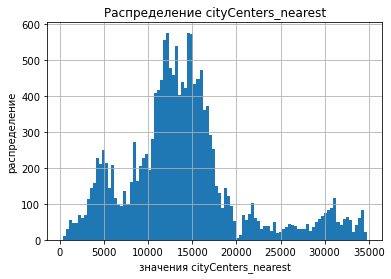

In [118]:
apartments_good_center_near = apartments_good_airp_near.query('cityCenters_nearest <= 50000')
histogram(apartments_good_center_near, 'cityCenters_nearest', 100)

#### Число парков

Среднее значение по столбцу: 0.56
Максимальное "хорошее" значение по столбцу: 1.0


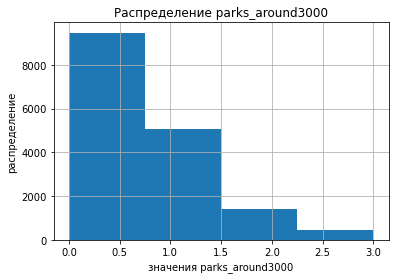

In [119]:
histogram(apartments_good_center_near, 'parks_around3000', 4)

В данных по количеству парков нет ни выбросов, ни слишком редко встречающихся значений.

#### Расстояние до парка

Среднее значение по столбцу: 495.87
Максимальное "хорошее" значение по столбцу: 454.0


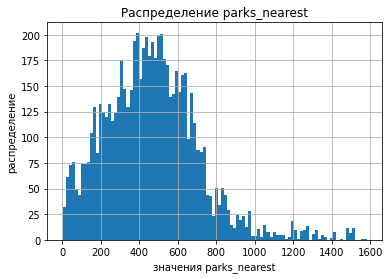

In [120]:
histogram(apartments_good_center_near, 'parks_nearest', 100)

Гистограмма по расстоянию до ближайшего парка близка к пуассоновскому распределению. После 1600 м наблюдается мало значений. Мы не будем их исключать, поскольку данный параетр не является ключевым в продаже квартир.

#### Число водоёмов

Среднее значение по столбцу: 0.71
Максимальное "хорошее" значение по столбцу: 1.0


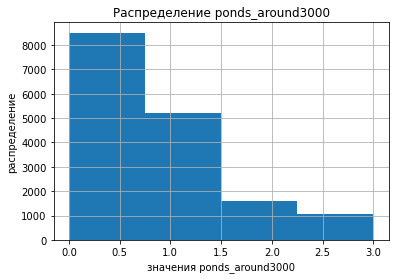

In [121]:
histogram(apartments_good_center_near, 'ponds_around3000', 4)

В данных по количеству парков нет ни выбросов, ни слишком редко встречающихся значений.

#### Расстояние до водоёма

Среднее значение по столбцу: 531.56
Максимальное "хорошее" значение по столбцу: 517.0


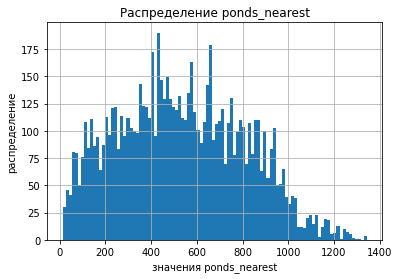

In [122]:
histogram(apartments_good_center_near, 'ponds_nearest', 100)

Гистограмма по расстоянию до ближайшего водоёма близка к пуассоновскому распределению. После 1 400 м наблюдается мало значений.
Мы не будем их исключать, поскольку данный параетр не является ключевым в продаже квартир.

#### Длительность размещения объявления

Среднее значение по столбцу: 175.89
Максимальное "хорошее" значение по столбцу: 89.50000000000001


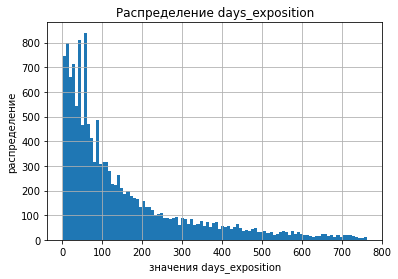

In [123]:
histogram(apartments_good_center_near, 'days_exposition', 100)

Распределение выглядит как пуассоновское с очень длинным "хвостом" после 1 000 дней. Немного странными выглядят объявления, которые закрываются за несколько дней, но скорее всего, это связано с деятельностью риэлторов, которые "вылавливают" "хорошие" квартиры.

Также мы должны помнить об одном крупном выбросе: это очень высокие значения, которыми мы заменяли пропущенные величины в данном столбце. Мы не будем их исключать, но будем проводить анализ с ними и без них.

In [124]:
# доля объявлений с квартирами, для которых время закрытия составляет более 1000 дней
print(len(apartments_good_center_near.query('days_exposition > 1000')) / len(apartments_good_center_near))

0.01141357421875


Значения в указанном промежутке составляют около 1% от данных, мы можем исключить их.

Среднее значение по столбцу: 162.85
Максимальное "хорошее" значение по столбцу: 89.00000000000001


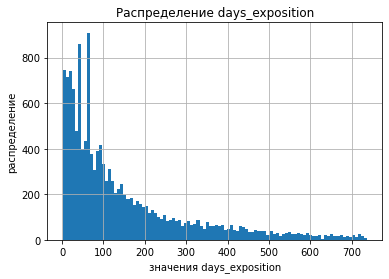

In [125]:
apartments_good_data = apartments_good_center_near.query('days_exposition <= 1000')
histogram(apartments_good_data, 'days_exposition', 100)

Мы оставили очень большое расстояние (или возможное его отсутствие) до парка в срезе с "хорошими" данными, чтобы не потерять большое число данных. Если будем работать с данным столбцом, эти данные нужно будет исключать из среза.

### Выделение и анализ факторов, влияющих на стоимость квартиры <a id='step_2.4'></a>

У нас есть данные по абсолютному значению цены, за которую была продана квартира. А есть данные по цене за квадратный метр. Рассмотрим влияние прочих факторов на оба этих параметра.

#### Квадратный метр

In [126]:
# сводная таблица для конечной стоимости
last_price_and_area = (
    apartments_good_data.pivot_table(values='total_area', index='last_price', aggfunc='median')
                        .reset_index()
                        .sort_values(by='total_area', ascending=False)
)
last_price_and_area.head()

,last_price,total_area
1759,15782000,159.0
1771,16070000,145.0
1747,15398992,139.2
1796,17414720,137.0
1760,15786435,135.0


In [127]:
# сводная таблица для стоимости квадратного метра
pricepermeter_and_area = (
    apartments_good_data.pivot_table(values='total_area', index='price_per_meter', aggfunc='median')
                        .reset_index()
                        .sort_values(by='total_area', ascending=False)
)
pricepermeter_and_area.head()

,price_per_meter,total_area
4249,99257,159.0
207,62179,156.0
1942,83225,155.0
2070,84360,154.1
1251,77857,154.0


In [128]:
# Создадим функцию расчёта коэффициентов корреляции
def corr(df_price, df_price_per_meter, corr_column):
    print('Коэффициент корреляции между ценой и параметром {} равен {}.'
          .format(corr_column, df_price['last_price'].corr(df_price[corr_column])))
    print('Коэффициент корреляции между ценой м2 и параметром {} равен {}.'
          .format(corr_column, df_price_per_meter['price_per_meter'].corr(df_price_per_meter[corr_column])))

Рассчитаем коэффициенты корреляции для обоих вариантов и построим графики.

In [129]:
corr(last_price_and_area, pricepermeter_and_area, 'total_area')

Коэффициент корреляции между ценой и параметром total_area равен 0.8518972209590588.
Коэффициент корреляции между ценой м2 и параметром total_area равен -0.05806547754425208.


In [130]:
# Создадим функцию построения графиков зависимости между параметрами
def scatter(df_price, df_price_per_meter, corr_column, alpha1, alpha2):
    fig = plt.figure(figsize=(18,4))
    
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_2 = fig.add_subplot(1, 2, 2)
    
    ax_1.scatter(x=df_price[corr_column], y=df_price['last_price'], alpha=alpha1)
    ax_2.scatter(x=df_price_per_meter[corr_column], y=df_price_per_meter['price_per_meter'], alpha=alpha2)
    
    ax_1.set(title = 'График зависимости цены от параметра '+corr_column, xlabel=corr_column, ylabel='цена, ден.ед.')
    ax_2.set(title = 'График зависимости цены квадратного метра от параметра '+corr_column,
             xlabel=corr_column, ylabel='цена за м2, ден.ед.')
    
    plt.show()

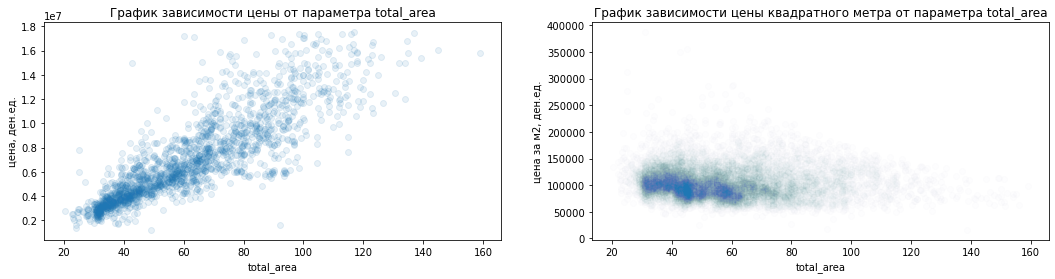

In [131]:
scatter(last_price_and_area, pricepermeter_and_area, 'total_area', 0.1, 0.008)

Получили очень слабую зависимость между ценой квадратного метра и общей площадью; но достаточно тесную зависимость между окончательной стоимостью и площадью. Это логично. В то время, как на цену квадратного метра влияет множество иных факторов, стоимость жилья рассчитывается умножением площади на стоимость квадратного метра. Отсюда и зависимость.

#### Число комнат

In [132]:
# сводная таблица для конечной стоимости
last_price_and_rooms = (
    apartments_good_data.pivot_table(values='rooms', index='last_price', aggfunc='median')
                        .reset_index()
                        .sort_values(by='rooms', ascending=False)
)
last_price_and_rooms.head()

,last_price,rooms
1672,13351000,6.0
1035,6864000,6.0
1520,10880000,6.0
1778,16550000,6.0
1677,13490000,5.5


In [133]:
# сводная таблица для стоимости квадратного метра
pricepermeter_and_rooms = (
    apartments_good_data.pivot_table(values='rooms', index='price_per_meter', aggfunc='median')
                .reset_index()
                .sort_values(by='rooms', ascending=False)
)
pricepermeter_and_rooms.head()

,price_per_meter,rooms
7645,134095,7.0
722,71599,6.0
1945,83250,6.0
4121,98319,6.0
2231,85460,6.0


Рассчитаем коэффициенты корреляции для обоих вариантов и построим графики.

In [134]:
corr(last_price_and_rooms, pricepermeter_and_rooms, 'rooms')

Коэффициент корреляции между ценой и параметром rooms равен 0.6398641060927679.
Коэффициент корреляции между ценой м2 и параметром rooms равен -0.25742075422432525.


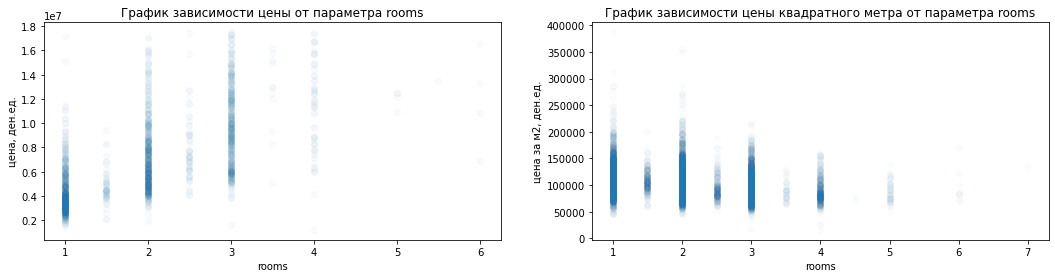

In [135]:
scatter(last_price_and_rooms, pricepermeter_and_rooms, 'rooms', 0.025, 0.015)

Получили слабую зависимость между окончательной ценой и количеством комнат, и отсутствие зависимости между ценой квадратного метра и количеством комнат. Первая зависимость может быть объяснена косвенным влиянием площади. Чем больше комнат, тем больше площадь; а чем больше площадь, тем выше стоимость, полученная произведением площади на цену квадратного метра.

#### Удалённость от центра

In [136]:
# сводная таблица для конечной стоимости
last_price_and_center = (
    apartments_good_data.pivot_table(values='cityCenters_nearest', index='last_price', aggfunc='median')
                        .reset_index()
                        .sort_values(by='cityCenters_nearest', ascending=False)
)
last_price_and_center.head()

,last_price,cityCenters_nearest
170,3149000,49854.0
34,2340000,49620.0
6,1799000,41435.0
83,2699000,39722.0
363,3936700,36307.0


In [137]:
# сводная таблица для стоимости квадратного метра
pricepermeter_and_center = (
    apartments_good_data.pivot_table(values='cityCenters_nearest', index='price_per_meter', aggfunc='median')
                        .reset_index()
                        .sort_values(by='cityCenters_nearest', ascending=False)
)
pricepermeter_and_center.head()

,price_per_meter,cityCenters_nearest
299,64462,49984.0
241,63140,49984.0
2535,87671,49980.0
1964,83561,49927.0
615,69977,49854.0


Рассчитаем коэффициенты корреляции для обоих вариантов и построим графики.

In [138]:
corr(last_price_and_center, pricepermeter_and_center, 'cityCenters_nearest')

Коэффициент корреляции между ценой и параметром cityCenters_nearest равен -0.4838880240269095.
Коэффициент корреляции между ценой м2 и параметром cityCenters_nearest равен -0.446171542461358.


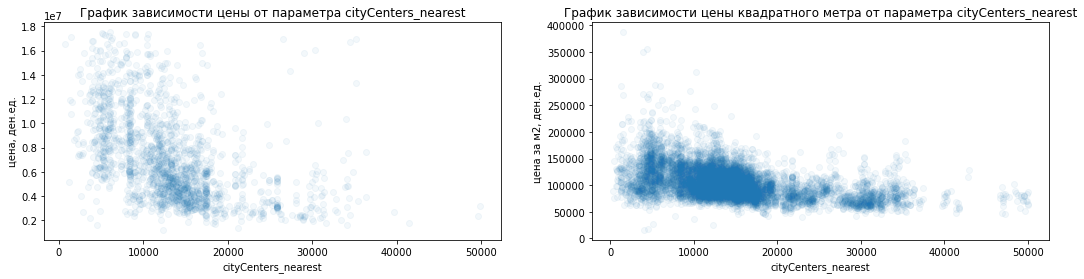

In [139]:
scatter(last_price_and_center, pricepermeter_and_center, 'cityCenters_nearest', 0.05, 0.05)

Зависимость как между итоговой стоимостью и близостью центра, так и между ценой за метр и близостью центра обратная и незначительная. Возможно, это связано с тем, что центр интересен с точки зрения исторической значимости и расположения офисов, но для проживания не обладает необходимой инфраструктурой (продуктовыми магазинами, школами, детскими садами), поэтому люди почти в равной степени готовы платить за центр и за "спальные" районы со всем необходимым.

#### Тип этажа

In [140]:
# сводная таблица для конечной стоимости
last_price_and_floorcat = (
    apartments_good_data.pivot_table(values='last_price', index='floor_category', aggfunc='median')
                .reset_index()
                .sort_values(by='last_price', ascending=False)
)
last_price_and_floorcat

,floor_category,last_price
0,другой,5000000
2,последний,4750000
1,первый,4350000


In [141]:
# сводная таблица для стоимости квадратного метра
pricepermeter_and_floorcat = (
    apartments_good_data.pivot_table(values='price_per_meter', index='floor_category', aggfunc='median')
                .reset_index()
                .sort_values(by='price_per_meter', ascending=False)
)
pricepermeter_and_floorcat

,floor_category,price_per_meter
0,другой,101408
2,последний,95304
1,первый,88556


In [142]:
# Запишем функцию для построения графика
def plot(df_price, df_price_per_meter, corr_column):
    fig = plt.figure(figsize=(18,4))
    
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_2 = fig.add_subplot(1, 2, 2)
    
    ax_1.plot(df_price[corr_column],
              df_price['last_price'],
              'og', 
              label='last_price')
    ax_2.plot(df_price_per_meter[corr_column],
              df_price_per_meter['price_per_meter'],
              'or',
              label='price_per_meter')
    
    ax_1.set(title = 'График зависимости цены от параметра '+corr_column,
             xlabel=corr_column,
             ylabel='цена, ден.ед.')
    ax_2.set(title = 'График зависимости цены квадратного метра от параметра '+corr_column,
             xlabel=corr_column,
             ylabel='цена за м2, ден.ед.')
    plt.show()

Построим графики для обоих вариантов.

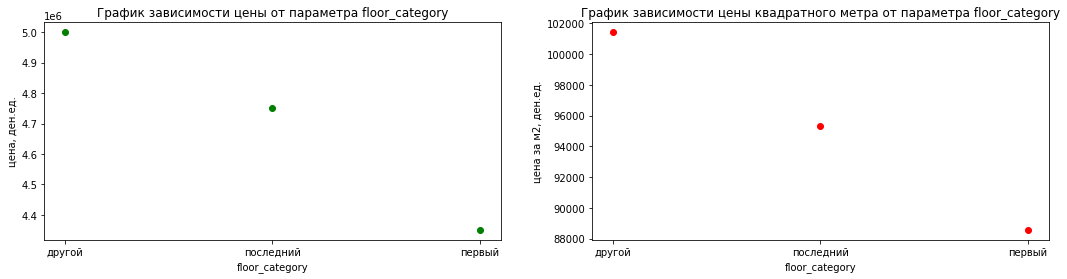

In [143]:
plot(last_price_and_floorcat, pricepermeter_and_floorcat, 'floor_category')

Для обоих результирующих переменных (стоимости и цены квадратного метра) получаем следующую связь с типом этажа, на котором расположена квартира: цены на квартиры, расположенные на первом этаже, самые низкие; цены на квартиры на последнем этаже чуть выше цен на первом, но всё еще не самые высокие; самые высокие цены на квартиры, расположенные на других этажах, кроме первого и последнего.

#### День недели, в который размещено объявление

In [144]:
# сводная таблица для конечной стоимости
last_price_and_weekday = (
    apartments_good_data.pivot_table(values='last_price', index='weekday_exposition', aggfunc='median')
                .reset_index()
                .sort_values(by='last_price', ascending=False)
)
last_price_and_weekday

,weekday_exposition,last_price
1,1,4980000
2,2,4950000
0,0,4900000
3,3,4900000
5,5,4900000
4,4,4850000
6,6,4826125


In [145]:
# сводная таблица для стоимости квадратного метра
pricepermeter_and_weekday = (
    apartments_good_data.pivot_table(values='price_per_meter', index='weekday_exposition', aggfunc='median')
                .reset_index()
                .sort_values(by='price_per_meter', ascending=False)
)
pricepermeter_and_weekday

,weekday_exposition,price_per_meter
2,2,100000.0
3,3,100000.0
5,5,99593.0
6,6,99510.0
1,1,99354.0
0,0,99084.5
4,4,98260.0


Построим графики для обоих вариантов.

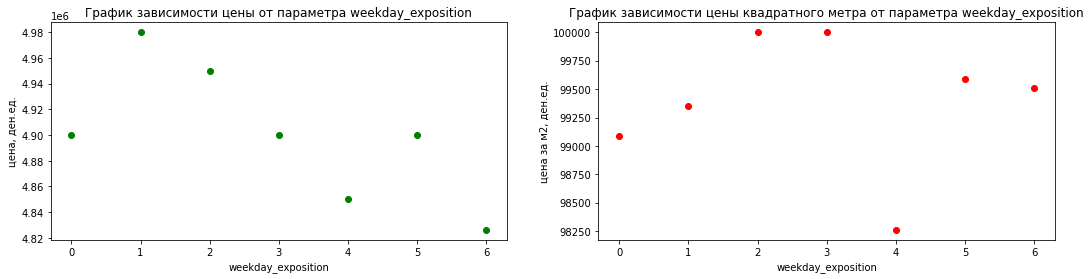

In [146]:
plot(last_price_and_weekday, pricepermeter_and_weekday, 'weekday_exposition')

Для итоговой стоимости жилья получили следующую зависимость: Объявления, выставленные в первые дни недели (понедельник-среда) продаются за среднюю и высокую стоимость; Объявления, выставленные в конце недели (четверг-воскресенье) продаются за среднюю и низкую стоимость. 

При этом цена квадратного метра не имеет явной тенденции. Только в объявлениях, которые выставлены по четвергам, она ниже всего.

Возможно, в этом можно проследить деятельность мошенников: в какой-то определенный день они выставляют объявления по заниженной стоимости, чтобы поднять объявление выше в поиске, и привлечь внимание потенциальных покупателей.

#### Месяц, в который размещено объявление

In [147]:
# сводная таблица для конечной стоимости
last_price_and_month = (
    apartments_good_data.pivot_table(values='last_price', index='month_exposition', aggfunc='median')
                .reset_index()
                .sort_values(by='last_price', ascending=False)
)
last_price_and_month

,month_exposition,last_price
11,12,5025097.5
3,4,5000000.0
8,9,4990000.0
0,1,4950000.0
1,2,4900000.0
2,3,4900000.0
6,7,4900000.0
7,8,4900000.0
10,11,4900000.0
4,5,4823000.0


In [148]:
# сводная таблица для стоимости квадратного метра
pricepermeter_and_month = (
    apartments_good_data.pivot_table(values='price_per_meter', index='month_exposition', aggfunc='median')
                .reset_index()
                .sort_values(by='price_per_meter', ascending=False)
)
pricepermeter_and_month

,month_exposition,price_per_meter
0,1,100671.0
7,8,100515.0
2,3,100000.0
8,9,100000.0
11,12,100000.0
1,2,99542.0
6,7,99253.0
10,11,98612.0
9,10,98570.0
3,4,98360.0


Построим графики для обоих вариантов.

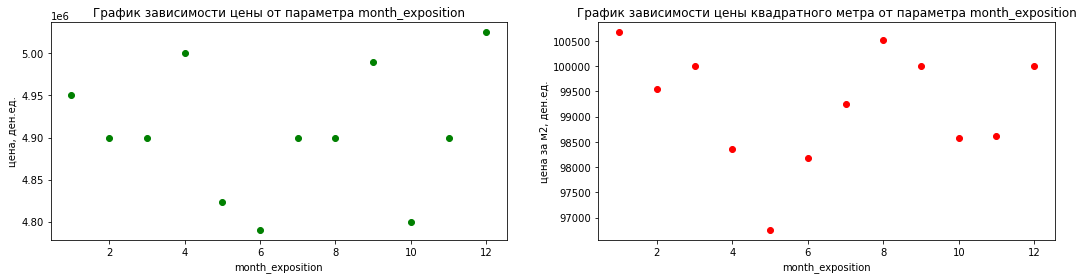

In [149]:
plot(last_price_and_month, pricepermeter_and_month, 'month_exposition')

Для обоих результирующих переменных (стоимости и цены квадратного метра) получились графики с похожими тенденциями: объявления, выставленные в январе-апреле, были проданы за среднюю цену (но высокую стоимость квадратного метра); в мае-июне - за самую низкую (стоимость и цену м2); в июле-ноябре - за среднюю (стоимость и цену м2); и в декабре - за самую высокую цену (и достаточно высокую стоимость квадратного метра). Таким образом, наблюдается некоторая сезонность в стоимости квартир, связанная с сезонностью спроса на недвижимость: как только растет спрос, сразу же растут и цены.

#### Год, в который размещено объявление

In [150]:
# сводная таблица для конечной стоимости
last_price_and_year = (
    apartments_good_data.pivot_table(values='last_price', index='year_exposition', aggfunc='median')
                .reset_index()
                .sort_values(by='last_price', ascending=False)
)
last_price_and_year

,year_exposition,last_price
0,2014,6475000
1,2015,5265000
5,2019,5100000
2,2016,4900000
4,2018,4900000
3,2017,4800000


In [151]:
# сводная таблица для стоимости квадратного метра
pricepermeter_and_year = (
    apartments_good_data.pivot_table(values='price_per_meter', index='year_exposition', aggfunc='median')
                .reset_index()
                .sort_values(by='price_per_meter', ascending=False)
)
pricepermeter_and_year

,year_exposition,price_per_meter
5,2019,108481.0
0,2014,104323.0
4,2018,101562.0
3,2017,97065.0
2,2016,96292.5
1,2015,96153.0


Построим графики для обоих вариантов.

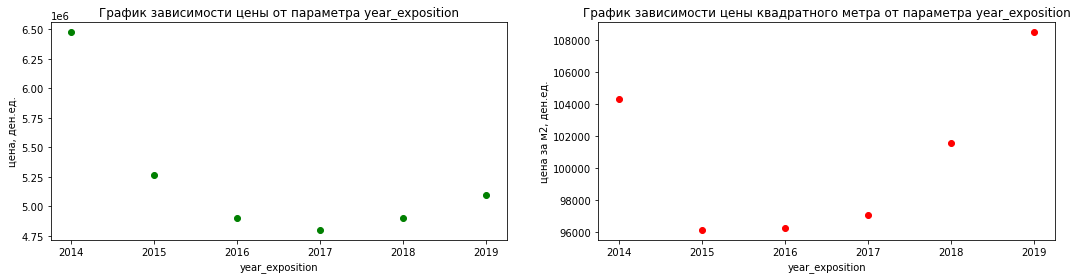

In [152]:
plot(last_price_and_year, pricepermeter_and_year, 'year_exposition')

Зависимости между годом объявления и итоговой ценой, и между годом объявления и ценой за квадратный метр выглядят следующим образом. В 2014 году наблюдается достаточно высокая стоимость квадратного метра и самая высокая цена продажи. Но, возможно, это связано с тем, что в 2014 году выборка самая маленькая, и величина не совсем показательна.

В укрупненном же виде стоимость квадратного метра росла с 2015 по 2019 год (что может быть связано с инфляцией или увеличением спроса), но при этом стоимость жилья снижалась до 2017 года, а затем начала расти. Возможно, наблюдалась тенденция застройки квартир с меньшей площадью - удобной для студентов и малобюджетных семей, а позже стали доступны многочисленные банковские ипотечные продукты, что привело к увеличению возможностей по покупке более дорогих квартир.

#### Общий анализ показателей

После изучения каждого из параметров в отдельности, изучим общую картину: рассмотрим взаимосвязи всех показателей через корреляцию, и визуализируем матрицу корреляций.

In [153]:
Correlation = apartments_good_data.corr()
Correlation

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_index,living_index,price_per_meter,weekday_exposition,month_exposition,year_exposition
total_images,1.000000,0.131775,0.082144,0.065401,0.029475,0.006112,0.071079,0.027358,0.016764,-0.018509,...,-0.009580,-0.023991,0.000334,-0.023384,-0.045326,0.012534,0.114314,0.000859,0.021924,0.129368
last_price,0.131775,1.000000,0.802709,0.530930,0.502581,0.060319,0.696258,0.053026,0.014142,-0.057633,...,0.053360,0.173089,-0.073083,0.128631,-0.240813,0.096922,0.522703,-0.004628,0.004211,-0.028054
total_area,0.082144,0.802709,1.000000,0.802053,0.474402,-0.027557,0.930721,-0.027226,0.003799,-0.088585,...,0.008853,0.117960,-0.040245,0.152549,-0.480542,0.280705,-0.047315,-0.004434,0.006539,-0.099985
rooms,0.065401,0.530930,0.802053,1.000000,0.260673,-0.228100,0.890212,-0.170349,-0.007573,-0.076475,...,-0.043267,0.045843,-0.017805,0.102059,-0.706171,0.613155,-0.232590,-0.005525,0.006287,-0.074244
ceiling_height,0.029475,0.502581,0.474402,0.260673,1.000000,-0.020292,0.401242,-0.011298,0.046263,0.007872,...,-0.033783,0.166564,-0.070662,0.114105,-0.046327,-0.004662,0.208973,-0.012713,-0.004115,-0.055492
floors_total,0.006112,0.060319,-0.027557,-0.228100,-0.020292,1.000000,-0.163781,0.658548,-0.012138,0.064266,...,0.099201,-0.112938,0.043982,-0.039352,0.367005,-0.387006,0.174246,0.026845,-0.004290,0.030440
living_area,0.071079,0.696258,0.930721,0.890212,0.401242,-0.163781,1.000000,-0.120172,-0.003798,-0.058089,...,-0.030141,0.092471,-0.024448,0.134950,-0.645140,0.590366,-0.131762,-0.004449,0.000035,-0.089125
floor,0.027358,0.053026,-0.027226,-0.170349,-0.011298,0.658548,-0.120172,1.000000,-0.004063,0.028639,...,0.080817,-0.068329,0.024212,-0.032752,0.256178,-0.269874,0.149787,0.016941,0.005822,0.019069
is_apartment,0.016764,0.014142,0.003799,-0.007573,0.046263,-0.012138,-0.003798,-0.004063,1.000000,-0.002629,...,-0.009942,0.014338,0.018935,0.000383,0.013586,-0.019961,0.016451,-0.012007,-0.000169,0.015141
studio,-0.018509,-0.057633,-0.088585,-0.076475,0.007872,0.064266,-0.058089,0.028639,-0.002629,1.000000,...,0.017368,-0.001150,0.003054,-0.013597,0.065556,0.083797,0.049165,-0.001314,0.007882,0.010460


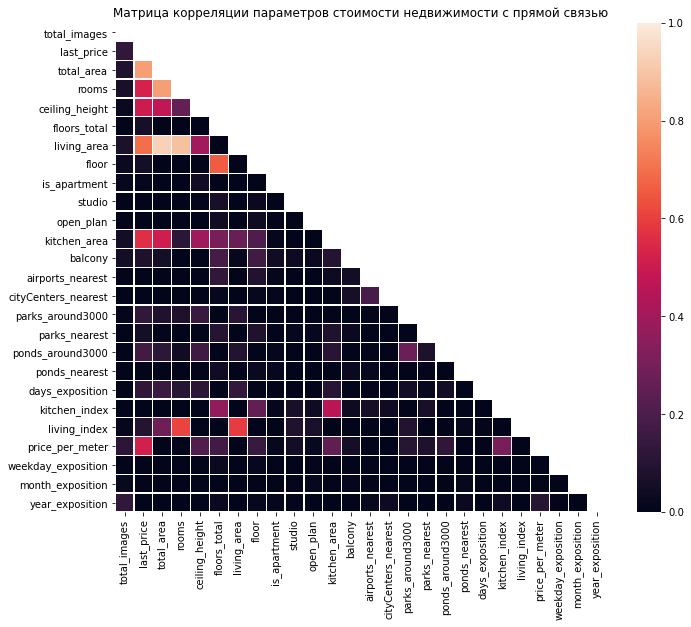

In [154]:
# график для прямой связи между переменными
fig, ax = plt.subplots(figsize=(11,9))
mask = np.triu(np.ones_like(Correlation, dtype=np.bool))
sns.heatmap(Correlation, vmin=0, vmax=1, linewidths=.3, mask=mask, ax=ax)
plt.title('Матрица корреляции параметров стоимости недвижимости с прямой связью')
plt.show()

Наблюдается достаточно тесная связь между стоимостью жилья и площадью жилья (в большей степени на стоимость влияет общая площадь, немного слабее влияние жилой площади, и еще слабее - площади кухни). Небольшое влияние на стоимость оказывает высота потолков, количество комнат и цена за м2. Но это, скорее, косвенное влияние, как было указано выше, которое прявляется через показатель площади.

На общую площадь оказывает значительное влияние количество комнат и величина жилой площади. Также есть небольшая связь между общей площадью и высотой потолков, а также между общей площадью и площадью кухни.

Количество комнат также влияет на жилую площадь, и, как следствие, на соотношение жилой площади к общей.

Есть достаточно плотная связь между количеством этажей в доме и этажом, на котором находится квартира в объявлении. Это объяснимо: количество этажей вводит ограничение на предложение. Соответственно, это сужает выборку по отдельным домам.

Есть очевидные связи между жилой площадью и соотношением жилой площади к общей, а также площади кухни и соотношением кухонной площади к общей, которые исходят из расчёта данных показателей.

Остальные факторы не окзывают существенного прямого влияния.

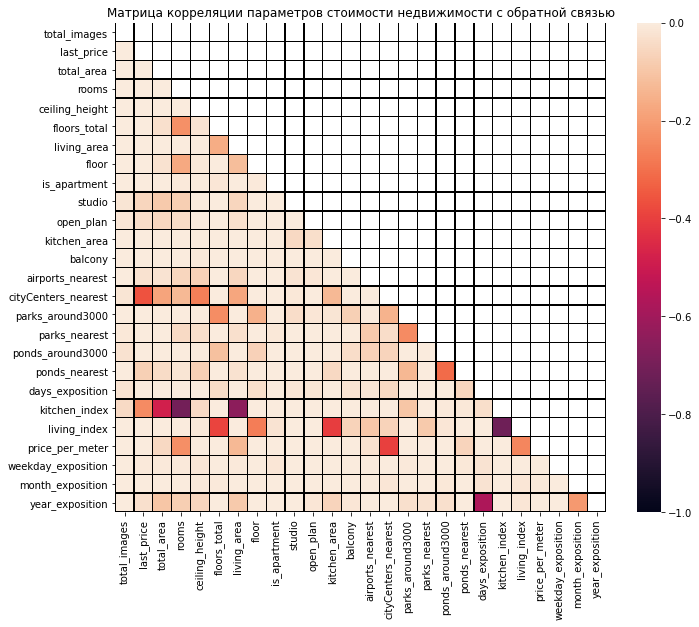

In [155]:
# график для обратной связи между переменными
fig, ax = plt.subplots(figsize=(11,9))
mask = np.triu(np.ones_like(Correlation, dtype=np.bool))
sns.heatmap(Correlation, vmin=-1, vmax=0, linewidths=.3, linecolor='black', mask=mask, ax=ax)
plt.title('Матрица корреляции параметров стоимости недвижимости с обратной связью')
plt.show()

Матрица корреляции подтверждает сделанные выше предположения по отдельным показателям: отдалённость от центра оказывает небольшое влияние на стоимость квартиры. Причём чем дальше жильё от центра, тем ниже стоимость. Однако, влияние несущественное. Также есть совсем небольшая обратная зависимость между соотношением площади кухни к общей и стоимостью квартиры. Это объясняется тем, что покупателей в большей степени интересует "полезная" площадь, т.е. "жилая", которая может быть использована под другие цели, кроме приготовления пищи. Тем не менее, этот фактор не является ключевым.

Есть явная обратная связь между соотношением площади кухни к общей и общей площадью: она следует из расчёта первого показателя. Также есть совсем небольшая зависимость между отдалённостью от центра и площадью жилья: чем дальше квартира от центра, тем меньше жильё. Возможно, это связано с особенностями застройки домов по районам, типами домов и квартир.

Также есть сильная обратная зависимость соотношения площади кухни к количеству комнат. Это, скорее всего, обусловлено уже выявленной нами сильной зависимостью между количеством комнат и общей площадью: чем больше комнат, там больше площадь, тем меньше соотношение кухонной площади (которая варьируется в меньшей степени, чем жилая) к общей.

Есть небольшая обратная связь между этажом, на котором расположена квартира, и соотношением жилой площади к общей. Этаж частично влияет на площадь квартиры. Соответственно, эту связь можно объяснить особенностями планировки на разных этажах (как правило, она разнится для первого, серединных и последнего этажей).

Также есть небольшая зависимость между отдалённостью от центра и площадью кухни. Скорее, это обусловлено зависимостью общей площади и отдалённости от центра (что было описано выше). Более плотная обратная связь между площадью кухни и соотношением жилой площади к общей. Эта связь, скорее всего, косвенная, выраженная через общую площадь. Чем выше площадь кухни, тем выше её доля в общей площади, и тем ниже доля жилой площади в общей.

Цена за квадратный метр зависит от отдалённости жилья от центра: чем дальше квартира от центра, тем ниже её цена за квадратный метр. Скорее всего, это связано со стоимостью земли, на которой строится жильё: в центре земля дороже, соответствено себестоимость застройки и конечная цена каждого квадратного метра выше.

Есть явная обратная зависимость между расстоянием до ближайшего парка и количеством парков поблизости; а также расстоянием до ближайшего водоёма и количеством водоёмов поблизости.

Наблюдается очень сильная обратная зависимость между длительностью размещения и годом публикации. Скорее всего, это связано с тем, что все квартиры рано или поздно продаются. Причём, как правило, большинство сделок является "короткими".

Есть небольшая обратная зависимость между соотношением жилой площади к общей и ценой за м2: чем выше соотношение жилой площади к общей, тем ниже цена квадратного метра. Скорее всего, это связано с относительной дешевизне квадратного метра больших квартир. Поскольку затраты на строительство каждого квадратного метра меньше, а спрос на большие квартиры тоже не так высок, как на маленькие, это находит отражение в стоимости.

Есть сильная обратная связь между соотношение жилой площади к общей и площади кухни к общей, которая связана с методикой расчёта данных показателей.

### Анализ недвижимости по расположению <a id='step_2.5'></a>

#### Анализ по населенным пунктам

Определим 10 населённых пунктов с наибольшим числом объявлений.

In [156]:
TOP_locality = apartments_good_data.groupby('locality_name')['total_area'].count().sort_values(ascending=False).head(10).index
TOP_locality

Index(['Санкт-Петербург', 'посёлок Шушары', 'Колпино', 'посёлок Парголово',
       'Пушкин', 'Петергоф', 'Красное Село', 'Сестрорецк',
       'посёлок Металлострой', 'Кронштадт'],
      dtype='object', name='locality_name')

Сделаем срез данных по населённым пунктам из полученного списка.

In [157]:
apartments_locality = apartments_good_data.loc[apartments_good_data['locality_name'].isin((TOP_locality)) == True]

Рассчитаем цену квадратного метра как медианную для каждого населенного пункта, составив сводную таблицу.

In [158]:
locality_pivot = (apartments_locality
                                      .pivot_table(index='locality_name', values='price_per_meter', aggfunc='median')
                                      .sort_values(by='price_per_meter', ascending=False)
                                      .reset_index()
)
locality_pivot

,locality_name,price_per_meter
0,Санкт-Петербург,101777.0
1,Сестрорецк,98128.5
2,Пушкин,97590.0
3,посёлок Парголово,91387.0
4,Кронштадт,81818.0
5,Петергоф,80952.0
6,посёлок Шушары,75933.0
7,посёлок Металлострой,74168.0
8,Колпино,73628.5
9,Красное Село,71785.5


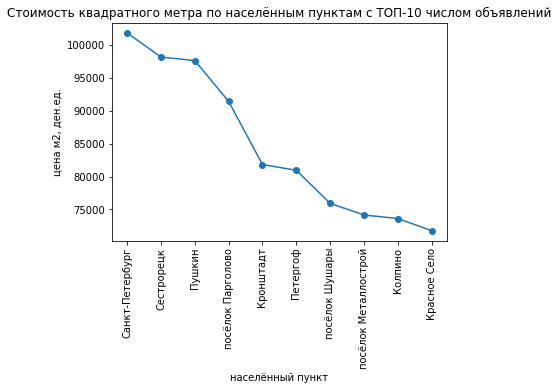

In [159]:
fig, ax = plt.subplots()
ax.set(title = 'Стоимость квадратного метра по населённым пунктам с ТОП-10 числом объявлений',
       xlabel='населённый пункт',
       ylabel='цена м2, ден.ед.')
ax.plot(locality_pivot['locality_name'], locality_pivot['price_per_meter'], 'o-')
plt.xticks(rotation='vertical')
plt.show()

Получили среднюю цену за квадратный метр по 10 населенным пунктам с наибольшим числом объявлений. Самые дорогие квартиры в Санкт-Петербурге, Сестрорецке, Пушкине, и посёлке Парголово. Причём уровень цен в этих населённых пунктах на порядок выше остальных. Средний уровень цен из представленных в Кронштадте и Петергофе: средние цены там практически идентичны. Самые дешёвые квартиры в посёлке Шушары, посёлке Металлострой, Колпино и Красном Селе.

#### Зависимость цены от расстояния до центра

Выделим квартиры в Санкт-Петербурге в отдельный срез данных.

In [160]:
apartments_spb = apartments_good_data.query('locality_name == "Санкт-Петербург"')

Создадим новый столбец с расстоянием до центра в километрах, разделив имеющийся столбец с расстоянием на 1 000, и округлив значение до целого.

In [161]:
apartments_spb['cityCenter_km'] = (apartments_spb['cityCenters_nearest'] / 1000).round().astype(int)

Посчитаем среднюю цену для каждого километра, построив сводную таблицу с медианным значением цены квадратного метра и сводную таблицу с медианным значением итоговой стоимости. Также построим графики для обоих случаев.

In [162]:
# зависимость итоговой стоимости жилья от расстояния
last_price_and_km = (apartments_spb
                         .pivot_table(index = 'cityCenter_km', values='last_price', aggfunc='median')
                         .reset_index())

In [163]:
# зависимость стоимости квадратного метра жилья от расстояния
pricepermeter_and_km = (apartments_spb
                            .pivot_table(index = 'cityCenter_km', values='price_per_meter', aggfunc='median')
                            .reset_index())

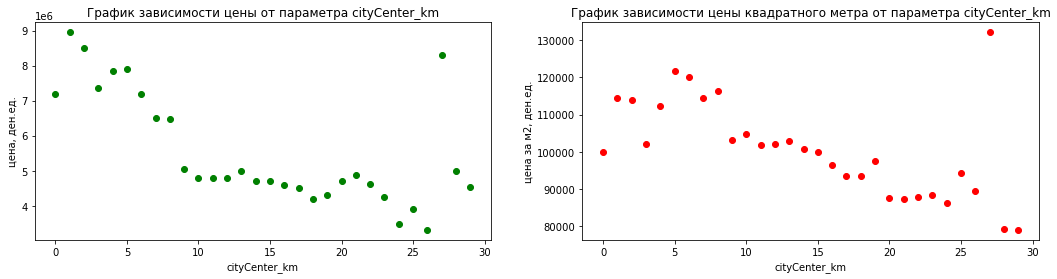

In [164]:
plot(last_price_and_km, pricepermeter_and_km, 'cityCenter_km')

Анализ данных в Санкт-Петербурге показал, что как для цен за квадратный метр, так и для итоговых цен на квартиры наблюдается следующая зависимость от расстояния от центра: чем дальше жилье от центра, тем дешевле жильё - до 27 километра. При расстоянии в 27 км квартиры самые дорогие. Возможно, это "элитный" пригород. В целом же видно, что "центром" считается радиус в 8 километров, потому что именно после этого значения наблюдается значительное изменение цен.

#### Анализ квартир в центре

Выделим квартиры в центре Санкт-Петербурга в отдельный срез данных.

In [165]:
apartments_spb_center = apartments_spb.query('cityCenter_km <= 8')

Помимо анализа каждого из показателей нового Датафрейма, нам понадобится провести сравнение показателей по всем данным и по центральной зоне. Для этого напишем функцию построения графиков, которые будут иллюстрировать это сравнение.

In [166]:
def plot_compare (column):
    try:
        plt.xlabel(apartments_good_data[column].name)
        plt.ylabel('плотность распределения')
        plt.title("Сопоставление распределений")
        sns.kdeplot(apartments_good_data[column], shade=True, label="все данные")
        sns.kdeplot(apartments_spb_center[column], shade=True, label="центральная зона")
    except:
        print()

##### Площадь квартиры

Среднее значение по столбцу: 68.70
Максимальное "хорошее" значение по столбцу: 65.35


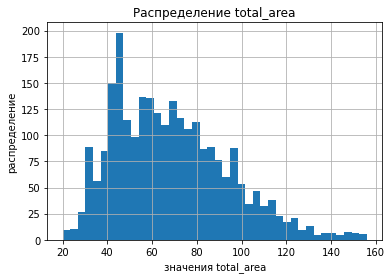

In [167]:
histogram(apartments_spb_center, 'total_area', 40)

В центре множество различных квартир с разной площадью, которые также подчиняются распределению Пуассона.

Наиболее часто в объявлениях встречаются квартиры площадью от 40 до 80 квадратных метров.

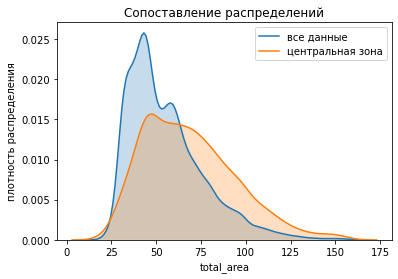

In [168]:
plot_compare('total_area')

В центральной зоне пик по площади более размыт, чем по всем данным. Он находится в диапазоне от 40 до 80 квадратных метров, и плавно уменьшается; в то время как по всем данным он лежит в пределах 25-40 квадратных метров и 50-60 м2.
Это говорит о приблизительно одинаковом типе застройки центра и схожем типе квартир по площади.

##### Жилая площадь

Среднее значение по столбцу: 40.59
Максимальное "хорошее" значение по столбцу: 37.23416666666667


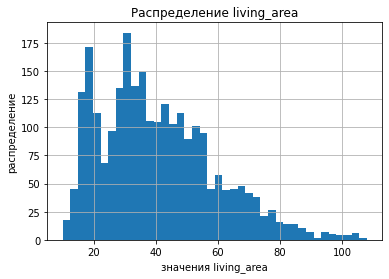

In [169]:
histogram(apartments_spb_center, 'living_area', 40)

Распределение жилой площади в центре Санкт-Петербурга имеет схожий вид с распределением жилой площади по всей выборке.

Есть два пиковых значения: квартиры с жилой площадью около 18 квадратных метров и квартиры с жилой площадью около 30 квадратных метров. Возможно, это связано с типом района в центре. Если это историческая часть города, то практически все строения в ней - жильё с небольшой жилой площадью. Если же это современная застраивающаяся часть центра, то в ней уже встречаются большие квартиры.

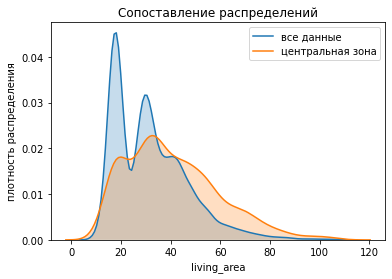

In [170]:
plot_compare('living_area')

В то время как вид диаграммы плотности распределения схож для всех данных и центральной зоны, для центральной зоны он более сглаженный, хотя и имеет пики в тех же значениях.

##### Площадь кухни

Среднее значение по столбцу: 11.20
Максимальное "хорошее" значение по столбцу: 10.229452736318407


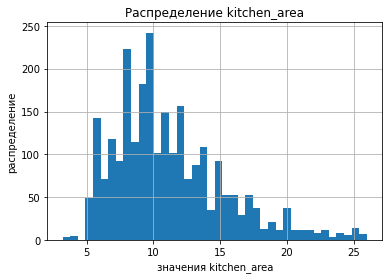

In [171]:
histogram(apartments_spb_center, 'kitchen_area', 40)

В центре, в отличие от всей выборки, нет такого большого количества квартир с небольшими кухнями. Основной пик приходится на кухни площадью от 8 до 12 квадратных метров.

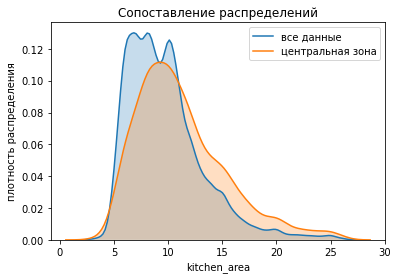

In [172]:
plot_compare('kitchen_area')

По сопоставлению распределений мы видим, что в центральной зоне, в отличие от всех данных, распределение ближе к пуассоновскому - с одним явным пиком около 10 м2. Что опять же говорит о типичности квартир в центре.

##### Стоимость квартиры

Среднее значение по столбцу: 8048227.52
Максимальное "хорошее" значение по столбцу: 7500000.0


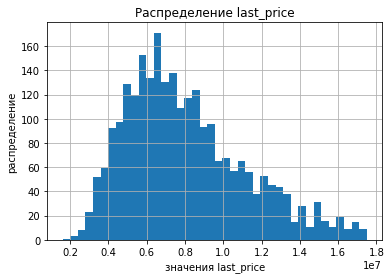

In [173]:
histogram(apartments_spb_center, 'last_price', 40)

Стоимость жилья достаточно высока и падает незначительно (что мы также заметили при выделении границ центра).

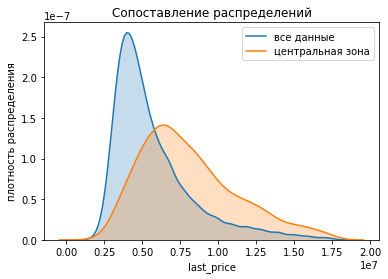

In [174]:
plot_compare('last_price')

В отличие от совокупной выборки, цены в центральной зоне колеблются незначительно.

##### Стоимость квадратного метра

Среднее значение по столбцу: 120587.26
Максимальное "хорошее" значение по столбцу: 115178.0


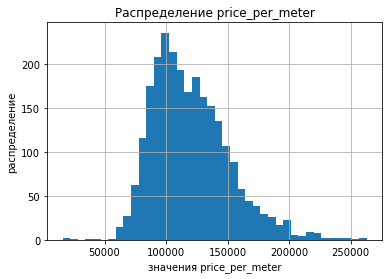

In [175]:
histogram(apartments_spb_center, 'price_per_meter', 40)

Стоимость квадратного метра имеет схожую со стоимостью жилья тенденцию.

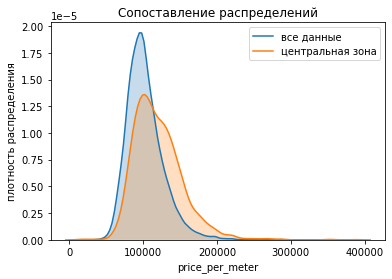

In [176]:
plot_compare('price_per_meter')

Цена за квадратный метр в центральной зоне также более сглажена, чем такая цена по всей совокупности данных. Это связано с тем, что квартиры в центре в несколько раз дороже квартир за пределами центральной зоны; но внутри центра цены не сильно меняются.

##### Число комнат

Среднее значение по столбцу: 2.38
Максимальное "хорошее" значение по столбцу: 3.0


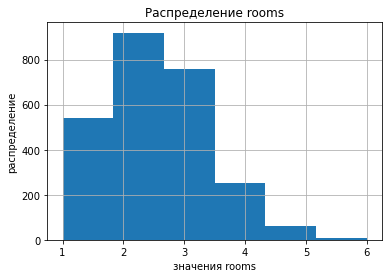

In [177]:
histogram(apartments_spb_center, 'rooms', 6)

В объявлениях по центральным квартирам Санкт-Петербурга в основном представлено 2-3 комнатное жильё. Вспомним, что в общей выборке преимущественно были представлены квартиры 1-2 комнатные.

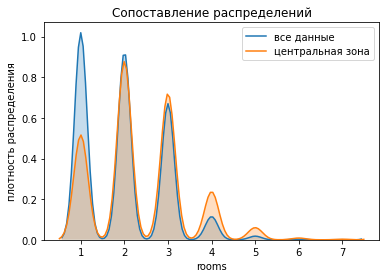

In [178]:
plot_compare('rooms')

Примечательно, что в центральной зоне очень мало объявлений по 1-комнатным квартирам, в отличие от объявлений по всем районам. Двухкомнатные и трёхкомнатные в центре так же популярны, как и по всем районам. А четырёхкомнатные и пятикомнатные квартиры наиболее популярны в центре, чем по всей выборке в совокупности.

##### Высота потолков

Среднее значение по столбцу: 2.82
Максимальное "хорошее" значение по столбцу: 2.76


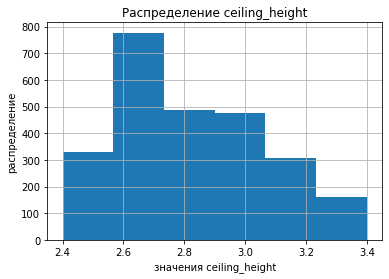

In [179]:
histogram(apartments_spb_center, 'ceiling_height', 6)

В рассматриваемых квартирах потолки преимущественно невысокие: около 2,5 метров. Однако, встречаются и 3-3,5 метра. Это опять же может быть связано с типом здания: историческое, или современное.

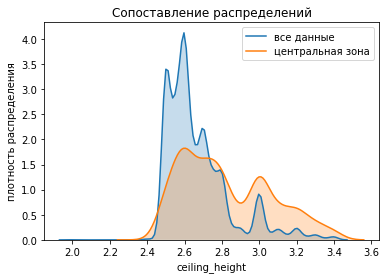

In [180]:
plot_compare('ceiling_height')

В центральной зоне очень сильно варьируется высота потолков: нет явного большого пика значений, в отличие от общих данных. То есть квартиры очень разноплановые: что подтверждает наше предположение о типах зданий.

##### Влияние числа комнат на стоимость

In [181]:
# сводная таблица для конечной стоимости
last_price_and_rooms_cen = (
    apartments_spb_center
                        .pivot_table(values='rooms', index='last_price', aggfunc='median')
                        .reset_index()
                        .sort_values(by='rooms', ascending=False)
)
last_price_and_rooms_cen.head()

,last_price,rooms
696,13490000,7.0
578,10880000,6.0
762,16550000,6.0
691,13351000,6.0
512,9650000,5.0


In [182]:
# сводная таблица для стоимости квадратного метра
pricepermeter_and_rooms_cen = (
    apartments_spb_center
                           .pivot_table(values='rooms', index='price_per_meter', aggfunc='median')
                           .reset_index()
                           .sort_values(by='rooms', ascending=False)
)
pricepermeter_and_rooms_cen.head()

,price_per_meter,rooms
1534,134095,7.0
995,111940,7.0
216,84360,6.0
248,85460,6.0
2048,172395,6.0


Рассчитаем коэффициенты корреляции для обоих вариантов и построим графики.

In [183]:
corr(last_price_and_rooms_cen, pricepermeter_and_rooms_cen, 'rooms')

Коэффициент корреляции между ценой и параметром rooms равен 0.5762345888701377.
Коэффициент корреляции между ценой м2 и параметром rooms равен -0.4066808056008854.


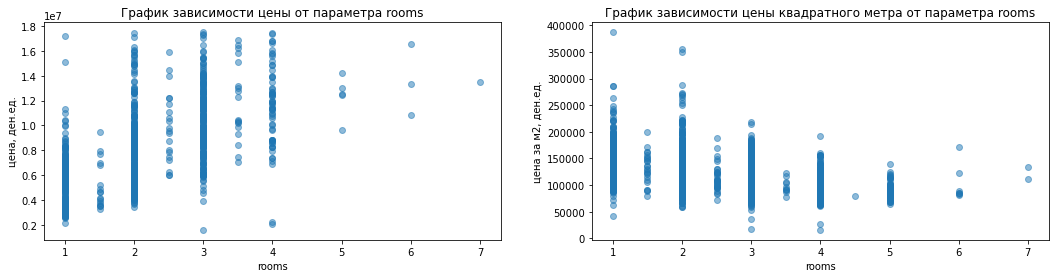

In [184]:
scatter(last_price_and_rooms_cen, pricepermeter_and_rooms_cen, 'rooms', 0.5, 0.5)

Получили небольшую зависимость между окончательной ценой и количеством комнат, и слабую обратную зависимость между ценой квадратного метра и количеством комнат. Скорее всего, это связано не с самим количеством комнат, а другими факторами, которые оказывают влияние как на количество комнат (площадь, тип здания, планировка), так и на стоимость.

##### Влияние типа этажа на стоимость

In [185]:
# сводная таблица для конечной стоимости
last_price_and_floorcat_cen = (
    apartments_spb_center
                        .pivot_table(values='last_price', index='floor_category', aggfunc='median')
                        .reset_index()
                        .sort_values(by='last_price', ascending=False)
)
last_price_and_floorcat_cen

,floor_category,last_price
0,другой,7735000.0
2,последний,7465000.0
1,первый,5878769.5


In [186]:
# сводная таблица для стоимости квадратного метра
pricepermeter_and_floorcat_cen = (
    apartments_spb_center
                        .pivot_table(values='price_per_meter', index='floor_category', aggfunc='median')
                        .reset_index()
                        .sort_values(by='price_per_meter', ascending=False)
)
pricepermeter_and_floorcat_cen

,floor_category,price_per_meter
0,другой,120600.5
2,последний,108163.0
1,первый,102926.0


Построим графики для обоих вариантов.

In [187]:
# Запишем функцию для построения сравнительных графиков
def plot_compare(df_price, df_price_cen, df_price_per_meter, df_price_per_meter_cen, corr_column):
    fig = plt.figure(figsize=(18,4))
    
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_2 = fig.add_subplot(1, 2, 2)
    
    ax_1.plot(df_price[corr_column],
              df_price['last_price'],
              '.g', 
              label='total')
    ax_1.plot(df_price_cen[corr_column],
              df_price_cen['last_price'],
              '.b', 
              label='center')
    ax_2.plot(df_price_per_meter[corr_column],
              df_price_per_meter['price_per_meter'],
              '.r',
              label='total')
    ax_2.plot(df_price_per_meter[corr_column],
              df_price_per_meter['price_per_meter'],
              '.k',
              label='center')
    
    ax_1.set(title = 'График зависимости цены от параметра '+corr_column,
             xlabel=corr_column,
             ylabel='цена, ден.ед.')
    ax_2.set(title = 'График зависимости цены квадратного метра от параметра '+corr_column,
             xlabel=corr_column,
             ylabel='цена за м2, ден.ед.')
    
    ax_1.legend()
    ax_2.legend()
    plt.show()

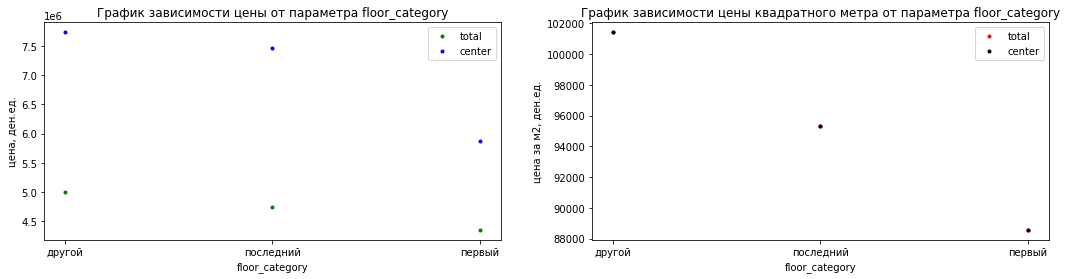

In [188]:
plot_compare(last_price_and_floorcat, last_price_and_floorcat_cen,
             pricepermeter_and_floorcat, pricepermeter_and_floorcat_cen,
             'floor_category')

Зависимость цены от типа этажа та же, что и для общего случая. Отличается только темп роста стоимости для последнего этажа: она ненаного ниже, чем стоимость других этажей, в то время как стоимость квадратного метра в разы ниже (как это было отмечено для всей выборки). Это, скорее всего, связано с другими факторами, например, видом с последнего этажа на центр города, реку Неву или какие-то достопримечательности; а также очень большой площадью квартир на последних этажах.

##### Влияние расстояния от центра на стоимость

In [189]:
# сводная таблица для конечной стоимости
last_price_and_center_cen = (
    apartments_spb_center
                        .pivot_table(values='cityCenters_nearest', index='last_price', aggfunc='median')
                        .reset_index()
                        .sort_values(by='cityCenters_nearest', ascending=False)
)
last_price_and_center_cen.head()

,last_price,cityCenters_nearest
23,3250000,8482.0
468,9009000,8467.0
170,5684221,8460.0
459,8945261,8460.0
552,10376552,8460.0


In [190]:
# сводная таблица для стоимости квадратного метра
pricepermeter_and_center_cen = (
    apartments_spb_center
                        .pivot_table(values='cityCenters_nearest', index='price_per_meter', aggfunc='median')
                        .reset_index()
                        .sort_values(by='cityCenters_nearest', ascending=False)
)
pricepermeter_and_center_cen.head()

,price_per_meter,cityCenters_nearest
2084,177777,8499.0
2067,175263,8488.0
2186,221568,8484.0
797,104838,8482.0
1405,128888,8479.0


Рассчитаем коэффициенты корреляции для обоих вариантов и построим графики.

In [191]:
corr(last_price_and_center_cen, pricepermeter_and_center_cen, 'cityCenters_nearest')

Коэффициент корреляции между ценой и параметром cityCenters_nearest равен -0.1736779561703868.
Коэффициент корреляции между ценой м2 и параметром cityCenters_nearest равен 0.03632462888833738.


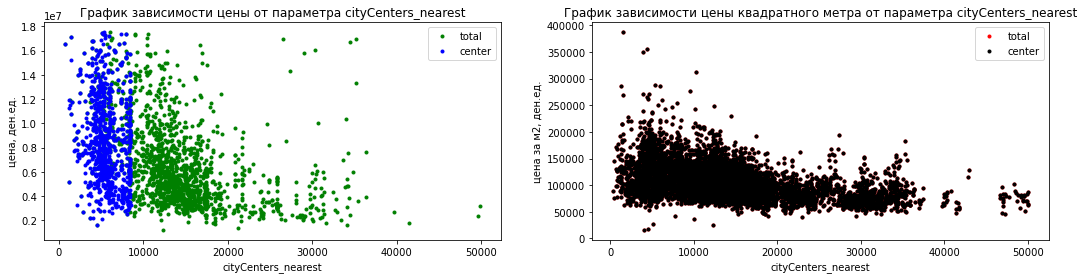

In [192]:
plot_compare(last_price_and_center, last_price_and_center_cen,
             pricepermeter_and_center, pricepermeter_and_center_cen,
             'cityCenters_nearest')

Между стоимостью жилья и расстоянием от центра нет зависимости, если квартира находится в радиусе 8 км. Порядок цен приблизительно один, и зависит от других факторов.

В общей выборке зависимость видна, но она не ключевая: очевидно, что имеются более существенные факторы, влияющие на стоимость квартиры.

##### Влияние дня недели, в который размещено объявление, на стоимость

In [193]:
# сводная таблица для конечной стоимости
last_price_and_weekday_cen = (
    apartments_spb_center
                        .pivot_table(values='last_price', index='weekday_exposition', aggfunc='median')
                        .reset_index()
                        .sort_values(by='last_price', ascending=False)
)
last_price_and_weekday_cen

,weekday_exposition,last_price
6,6,8100000
0,0,7500000
2,2,7450000
3,3,7405000
1,1,7400000
4,4,7400000
5,5,7302500


In [194]:
# сводная таблица для стоимости квадратного метра
pricepermeter_and_weekday_cen = (
    apartments_spb_center
                        .pivot_table(values='price_per_meter', index='weekday_exposition', aggfunc='median')
                        .reset_index()
                        .sort_values(by='price_per_meter', ascending=False)
)
pricepermeter_and_weekday_cen

,weekday_exposition,price_per_meter
5,5,120756
0,0,116441
4,4,115849
6,6,115178
3,3,114988
2,2,114406
1,1,113333


Построим графики для обоих вариантов.

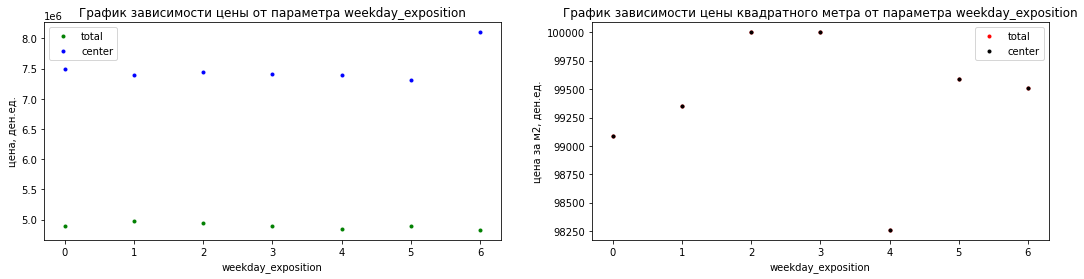

In [195]:
plot_compare(last_price_and_weekday, last_price_and_weekday_cen,
             pricepermeter_and_weekday, pricepermeter_and_weekday_cen,
             'weekday_exposition')

Для центральных квартир тенденции стоимости квадратного метра абсолютно идентичны стоимости квадратного метра по всей выборке.

Общая стоимость не имеет явной тенденции по дням недели.

##### Месяц, в который размещено объявление

In [196]:
# сводная таблица для конечной стоимости
last_price_and_month_cen = (
    apartments_spb_center
                        .pivot_table(values='last_price', index='month_exposition', aggfunc='median')
                        .reset_index()
                        .sort_values(by='last_price', ascending=False)
)
last_price_and_month_cen

,month_exposition,last_price
8,9,8150000
10,11,7700000
6,7,7595000
0,1,7500000
2,3,7500000
5,6,7500000
3,4,7400000
4,5,7400000
1,2,7395000
7,8,7300000


In [197]:
# сводная таблица для стоимости квадратного метра
pricepermeter_and_month_cen = (
    apartments_spb_center
                        .pivot_table(values='price_per_meter', index='month_exposition', aggfunc='median')
                        .reset_index()
                        .sort_values(by='price_per_meter', ascending=False)
)
pricepermeter_and_month_cen

,month_exposition,price_per_meter
2,3,125690.0
7,8,121500.0
0,1,119607.0
8,9,116979.5
4,5,115296.0
3,4,115178.0
6,7,114171.5
1,2,114057.0
9,10,113280.5
5,6,113243.0


Построим графики для обоих вариантов.

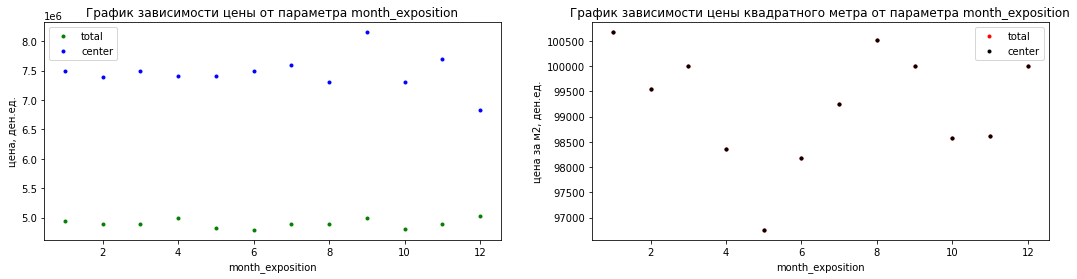

In [198]:
plot_compare(last_price_and_month, last_price_and_month_cen,
             pricepermeter_and_month, pricepermeter_and_month_cen,
             'month_exposition')

Для жилья в центре нет явной тенденции цен по месяцам продаж: вне зависимости от сезона, они остаются приблизительно на одном уровне. Это характерно и для стоимости квадратного метра, и для стоимости жилья в целом.

##### Год, в который размещено объявление

In [199]:
# сводная таблица для конечной стоимости
last_price_and_year_cen = (
    apartments_spb_center
                        .pivot_table(values='last_price', index='year_exposition', aggfunc='median')
                        .reset_index()
                        .sort_values(by='last_price', ascending=False)
)
last_price_and_year_cen

,year_exposition,last_price
0,2014,8585256
2,2016,7800000
3,2017,7429000
1,2015,7400000
4,2018,7400000
5,2019,7300000


In [200]:
# сводная таблица для стоимости квадратного метра
pricepermeter_and_year_cen = (
    apartments_spb_center
                        .pivot_table(values='price_per_meter', index='year_exposition', aggfunc='median')
                        .reset_index()
                        .sort_values(by='price_per_meter', ascending=False)
)
pricepermeter_and_year_cen

,year_exposition,price_per_meter
5,2019,127080.0
0,2014,120360.0
4,2018,117647.0
3,2017,113528.5
2,2016,113087.0
1,2015,111702.0


Построим графики для обоих вариантов.

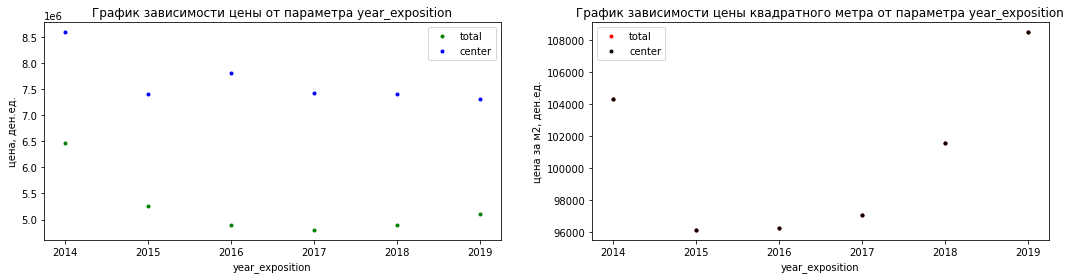

In [201]:
plot_compare(last_price_and_year, last_price_and_year_cen,
             pricepermeter_and_year, pricepermeter_and_year_cen,
             'year_exposition')

Зависимости между годом объявления и итоговой ценой, и между годом объявления и ценой за квадратный метр аналогичны таким зависимостям для всей выборки. Соответственно, на них влияют другие факторы (не расположение относительно центра).

##### Общий анализ показателей

После изучения каждого из параметров в отдельности, изучим общую картину по центральной зоне: рассмотрим взаимосвязи всех показателей через корреляцию, и визуализируем матрицу корреляций.

In [202]:
Correlation_cen = apartments_spb_center.corr()
Correlation_cen

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,ponds_around3000,ponds_nearest,days_exposition,kitchen_index,living_index,price_per_meter,weekday_exposition,month_exposition,year_exposition,cityCenter_km
total_images,1.000000,0.068497,0.000521,0.018840,0.029643,-0.047267,0.001327,0.019539,-0.008409,-0.019871,...,-0.019124,0.002771,-0.050357,-0.000351,-0.001201,0.089467,0.019248,0.016721,0.137712,0.008620
last_price,0.068497,1.000000,0.721479,0.477339,0.311684,0.116943,0.615534,0.146968,-0.001731,-0.056790,...,0.081186,-0.008203,0.141467,-0.205705,0.069993,0.420944,-0.011910,0.007264,-0.056308,-0.159350
total_area,0.000521,0.721479,1.000000,0.808590,0.411849,-0.074713,0.930474,-0.017679,-0.009582,-0.076744,...,0.021498,0.008564,0.177022,-0.485799,0.296861,-0.277167,-0.017936,0.031284,-0.124626,-0.225132
rooms,0.018840,0.477339,0.808590,1.000000,0.359406,-0.245254,0.872202,-0.139337,0.020675,-0.091698,...,-0.024127,-0.027712,0.107368,-0.638643,0.557932,-0.386857,-0.029045,0.020738,-0.074028,-0.229719
ceiling_height,0.029643,0.311684,0.411849,0.359406,1.000000,-0.227742,0.398548,-0.145990,0.000398,0.008201,...,0.028856,-0.037143,0.119791,-0.193236,0.158538,-0.081253,-0.036615,-0.005745,-0.011305,-0.256285
floors_total,-0.047267,0.116943,-0.074713,-0.245254,-0.227742,1.000000,-0.194914,0.672609,0.005631,0.029859,...,0.008094,0.059438,-0.021129,0.266417,-0.356599,0.261656,0.030373,-0.011526,-0.001991,0.409534
living_area,0.001327,0.615534,0.930474,0.872202,0.398548,-0.194914,1.000000,-0.093695,-0.008290,-0.052813,...,-0.004431,0.007572,0.149233,-0.632149,0.602636,-0.339532,-0.030294,0.027019,-0.104238,-0.233950
floor,0.019539,0.146968,-0.017679,-0.139337,-0.145990,0.672609,-0.093695,1.000000,-0.001365,-0.023578,...,0.000393,0.044682,-0.008789,0.139981,-0.211843,0.226340,0.035772,0.001570,0.001476,0.283767
is_apartment,-0.008409,-0.001731,-0.009582,0.020675,0.000398,0.005631,-0.008290,-0.001365,1.000000,-0.002367,...,0.035972,-0.007325,-0.026097,0.010979,-0.004198,0.012566,-0.031385,-0.020107,0.008220,-0.003940
studio,-0.019871,-0.056790,-0.076744,-0.091698,0.008201,0.029859,-0.052813,-0.023578,-0.002367,1.000000,...,-0.009012,0.014441,-0.018324,0.072141,0.057643,0.027666,0.003671,0.013594,0.004847,0.006801


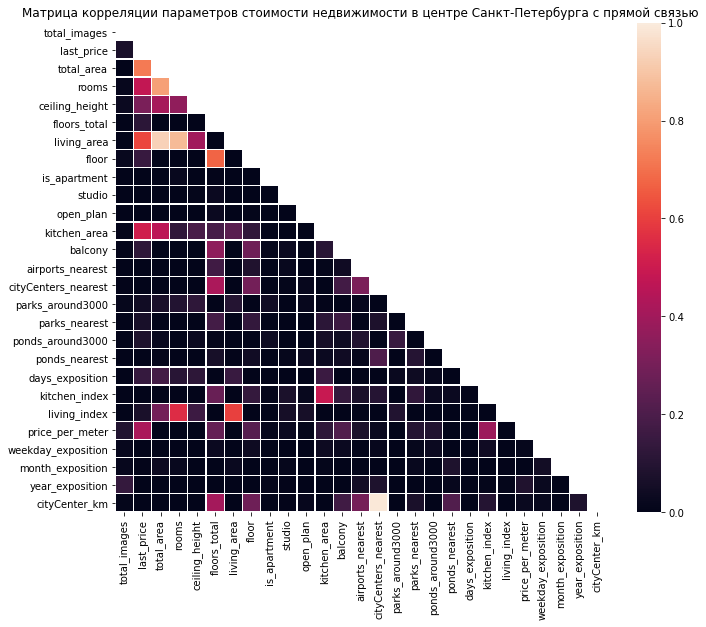

In [203]:
# график для прямой связи между переменными
fig, ax = plt.subplots(figsize=(11,9))
mask = np.triu(np.ones_like(Correlation_cen, dtype=np.bool))
sns.heatmap(Correlation_cen, vmin=0, vmax=1, linewidths=.3, mask=mask, ax=ax)
plt.title('Матрица корреляции параметров стоимости недвижимости в центре Санкт-Петербурга с прямой связью')
plt.show()

Для центральной зоны наблюдаются следующие зависимости. Стоимость жилья зависит от общей площади, жилой площади и площади кухни (то же мы наблюали для совокупной выборки). Количество комнат косвенно влияет на стоимость жилья.

Общая площадь зависит от жилой площади, площади кухни и количества комнат.

Количество комнат влияет на жилую площадь и, как следствие, на соотношение жилой площади к общей.

Высота потолков практически не оказывает влияния на другие параметры. Как мы заметили выше, в центре квартиры продаются с варьирующимся значением высоты потолков, что говорит о разных типах зданий.

Как и в общем случае, есть связь между количеством этажей в доме и этажом, на котором расположена квартира, так как это задаёт дополнительное ограничение.

Жилая площадь напрямую влияет на показатель доли жилой в общей площади; а площадь кухни - на долю кухни в общей площади, что исходит из расчёта показателей.

Все остальные факторы в центральной зоне не оказывают друг на друга прямого влияния.

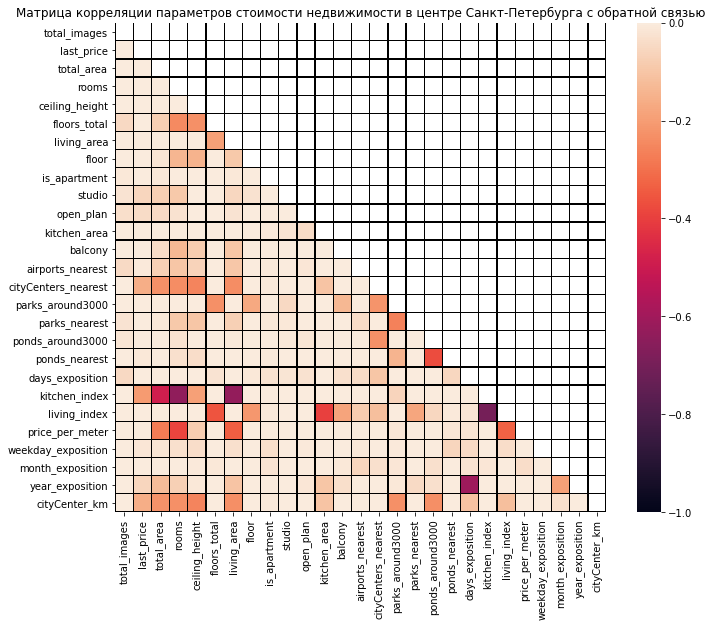

In [204]:
# график для обратной связи между переменными
fig, ax = plt.subplots(figsize=(11,9))
mask = np.triu(np.ones_like(Correlation_cen, dtype=np.bool))
sns.heatmap(Correlation_cen, vmin=-1, vmax=0, linewidths=.3, linecolor='black', mask=mask, ax=ax)
plt.title('Матрица корреляции параметров стоимости недвижимости в центре Санкт-Петербурга с обратной связью')
plt.show()

Как и в случае с общей выборкой, наиболее явно, с точки зрения обратной зависимости, проявляются количество комнат и соотношение кухонной площади к общей; жилая площадь и соотношение кухонной площади к общей; соотношение жилой площади к общей и соотношение кухонной площади к общей. Но все эти показатели связаны через расчёты, и важной смысловой нагрузки это не имеет.

Также как и в общей выборке, есть сильная зависимость между сроком объявления и годом выставления. Это объяснялось ранее при анализе общей выборки.

Во многом для центральных квартир в Санкт-Петербурге повторяются тенденции и зависимости, характерные для всего города. Небольшие отличия, скорее всего, вызваны возникновением других факторов. Например, принадлежностью района к исторической или более современной части города. Или, возможно, типом планировки (например, может отличаться площадь квартир на последних этажах). В рамках центра же цена меняется незначительно: она схожа как для 0 км, так и для 8 км, и зависит от иных факторов.

Однако, в центре очень мало факторов, оказывающих прямое или обратное влияние на цену. В совокупности по всем районам их намного больше.

### Вывод <a id='step_2.6'></a>

Мы изучили факторы, которые могут влиять на стоимость квартиры. Рассматривалось влияние как на окончательную стоимость жилья, так и на стоимость квадратного метра.

В процессе анализа было выявлено, что большинство квартир продается достаточно быстро: за 3-4 месяца, согласно медианному значению. Но среднее значение больше медианы почти в 2 раза, что говорит о длинном хвосте высоких значений в распределении данных. Несмотря на то, что мы имеем огромное число квартир, которые так и не были проданы, мы имеем следующую тенденцию. Число квартир убывает с ростом срока продажи. Другими словами, если квартира "хорошая", она имеет высокий шанс быть проданой в течение года. Далее ее шанс на продажу падает. В связи с этим и количество продаж квартир за 1-2 года в несколько раз меньше, чем за год; а за 2-3 года их число насчитывает только десятки.

Между ценой квадратного метра и общей площадью существует очень слабая зависимость; а между окончательной стоимостью и площадью - очень сильная. Число комнат напрямую не влияет на стоимость - только через площадь квартиры. Удаленность от центра имеет слабое обратное влияние на оба показателя: цены квартир в центре чуть выше цен квартир вне центра; однако существуют и дорогие квартиры в "спальных" районах со всей необходимой инфраструктурой. 

Есть прямое влияние типа этажа на стоимость метра и итоговую цену: первые этажи самые дешевые, последние - дороже, а не относящиеся к крайним - самые дорогие. День недели, в который выставлено объявление оказывает влияние на стоимость и цену. Месяц характеризуется некоторой сезонностью: есть "пиковые" по цене месяцы, есть "упадочные", что, скорее всего, соответствует сезонности спроса на недвижимость. Из года в год наблюдалась тенденция увеличения цены квадратного метра; однако, стоимость имела двоякую тенденцию - сначала она падала, затем росла. Это может быть связано с другими факторами (застройкой домами с квартирами меньшей площади, покупательной способностью, возможностями по ипотеке и т.д.).

## Общий вывод <a id='step_3'></a>

В исследовании **были проанализированы** данные объявлений о продаже квартир в городе Санкт-Петербурге и пригороде, которые включают в себя такие характеристики как число фотографий, цену, площадь квартиры, дату публикации, число комнат, высоту потолков, этажность дома, жилую площадь, этаж, апартаменты, принадлежность квартиры к студии, наличие свободной планировки, площадь кухни, число балконов, название населённого пункта, расстояние до ближайшего аэропорта, центра города, парка и водоёма, число парков и водоёмов в радиусе 3 км, длительность размещения объявления.

Нами были **рассчитаны и добавлены** в таблицу данные по цене квадратного метра; дню недели, месяцу и году публикации объявления; категории этажа квартиры; соотношению жилой и кухонной площадей к общей площади. Эти вспомогательные данные использовались для исследовательского анализа.

В процессе анализа было выявлено, что **большинство квартир продается достаточно быстро**: за 3-4 месяца, согласно медианному значению. Но среднее значение больше медианы почти в 2 раза, что говорит о длинном хвосте высоких значений в распределении данных. Несмотря на то, что мы имеем огромное число квартир, которые так и не были проданы, мы имеем следующую тенденцию. Число квартир убывает с ростом срока продажи. Другими словами, если квартира "хорошая", она имеет высокий шанс быть проданой в течение года. Далее ее шанс на продажу падает. В связи с этим и количество продаж квартир за 1-2 года в несколько раз меньше, чем за год; а за 2-3 года их число насчитывает только десятки.

Мы изучили **факторы, которые могут влиять на стоимость квартиры**. Рассматривалось влияние как на окончательную стоимость жилья, так и на стоимость квадратного метра. Между ценой квадратного метра и общей площадью существует очень слабая зависимость; а между окончательной стоимостью и площадью - очень сильная. Число комнат напрямую не влияет на стоимость - только через площадь квартиры. Удаленность от центра имеет слабое обратное влияние на оба показателя: цены квартир в центре чуть выше цен квартир вне центра. 

Однако, это относится к городу в целом. **Для центральной зоны, которая определяется радиусом в 8 км**, такая зависимость не характерна: цены зависят от других факторов, которых в рамках центральной зоны намного меньше, чем во всех районах в целом. Тип этажа напрямую влияет на стоимость метра и итоговую цену: первые этажи самые дешевые, последние - дороже, а не относящиеся к крайним - самые дорогие. Однако в центральных квартирах стоимость квартир на последних этажах ненамного ниже стоимости на других этажах, что может быть связано с площадью, типом здания и планировкой. День недели, в который выставлено объявление, не оказывает влияния на стоимость и цену. Месяц по городу характеризуется некоторой сезонностью, в то время как для центрального района он не оказывает влияния. Из года в год наблюдалась тенденция увеличения цены квадратного метра; однако, стоимость имела двоякую тенденцию - сначала она падала, затем росла. Это же характерно для центральной зоны.

Так, в процессе исследования были построены следующие **рабочие гипотезы**:
* цена жилья зависит от квадратного метра, числа комнат и удалённости от центра. 
* цена жилья зависит от того, на каком этаже расположена квартира: первом, последнем или другом. 
* цена жилья зависит от даты размещения: дня недели, месяца и года.
* существует центральная зона в Санкт-Петербурге, в пределах которого квартиры не меняют своей стоимости.
* квартиры в центральной зоне имеют те же характеристики и зависимости цены от других факторов, что и квартиры по всему городу.

В результате **первая гипотеза частично подтверждена, вторая гипотеза подтверждена, третья гипотеза частично подтверждена, четвертая гипотеза подтверждена, и пятая гипотеза частично подтверждена**.

## Рекомендации <a id='step_4'></a>

На основе исследования были разработаны следующие **рекомендации по построению автоматизированной системы**, способной отслеживать аномалии и мошенническую деятельность на рынке недвижимости в г.Санкт-Петербурге и пригороде.

1) Отслеживать срок продажи недвижимости: он, в среднем, должен составлять около 3-4 месяцев.

2) Отслеживать стоимость жилья в совокупности с площадью: чем выше площадь, тем выше должна быть стоимость.

3) Учитывать, что цены квартир в центре (центральная зона находится в радусе 8 км) чуть выше цен квартир, находящихся вне центра.

4) Однако, существует "элитный район" в пригороде, в котором цены недвижимости очень высокие - он должен оцениваться отдельно.

5) Учитывать, что вне центральной зоны тип этажа напрямую влияет на стоимость метра и итоговую цену: первые этажи самые дешевые, последние - дороже, а не относящиеся к крайним - самые дорогие.

6) Учитывать, что в центральных квартирах стоимость квартир на последних этажах ненамного ниже стоимости на других этажах, что может быть связано с площадью, типом здания и планировкой.